# XPCS&XSVS Pipeline for Mulit-SAXS Runs
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
from chxanalys.chx_xpcs_xsvs_jupyter import run_xpcs_xsvs_single
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Control Multi-Runs Parameters

In [2]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = False   #run waterfall analysis
run_t_ROI_Inten =  False #True  #run  ROI intensity as a function of time
run_one_time = False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = True#False   #run  four-time
run_xsvs= False          #run visibility analysis
att_pdf_report = False    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5

taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

In [3]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True# #False   #run waterfall analysis
run_t_ROI_Inten = True# False #True  #run  ROI intensity as a function of time
run_one_time = True#False   #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True#False #True #True #False    #run  two-time
run_four_time = False #True#False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name

good_start = 5


taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [4]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


In [5]:
#count : 1 ['6fdd55'] (scan num: 10457) (Measurement: sample X2 50nm Au in 2.5% PEG_slow_series_#0 )
uid_average=  'Au50_2p5PEGX2_vs_20us_120116' #give a meaningful folder name 
uid_average=  'Test_120116' #give a meaningful folder name 
 
data_dir = os.path.join( data_dir0, uid_average +'/')
os.makedirs(data_dir, exist_ok=True)
print ( data_dir )
uid_average = 'uid=' + uid_average

/XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [6]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy' 
#mask_name = 'Dec3_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


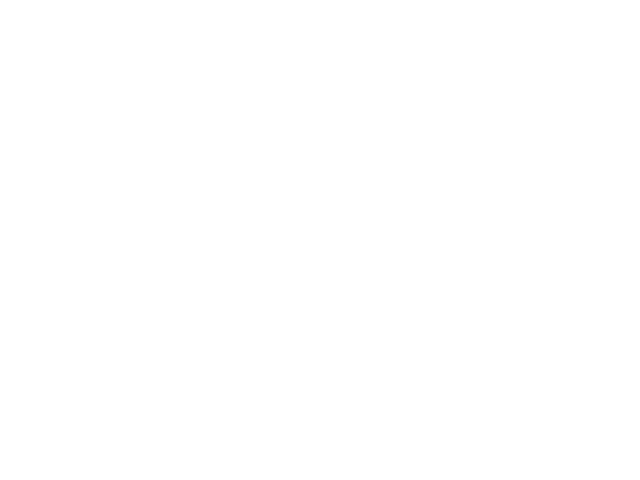

In [7]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s_mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = '%s_mask'%uid_average, save=True, path=data_dir)
mask_load=mask.copy()

## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [8]:
start_time, stop_time = '2016-12-2  11:05', '2016-12-2  11:14:00' #for coralpor, 10,20,40,80,160,320,640   
start_time, stop_time = '2016-12-1  16:30:00', '2016-12-1  16:31:50' #for 10 nm, 20, for test purpose 
sids, uids, fuids = find_uids(start_time, stop_time)
print( uids )
uid = uids[0]
uidstr = 'uid=%s'%uid

Totally 3 uids are found.
['83a2889e' '15de40bd' '5d1e13a7']


In [9]:
guids, buids = check_bad_uids( uids, mask, img_choice_N = 3 )
print( 'The good uids are: %s.\nThe good uids length is %s.'%(guids, len(guids)) )

hdf5 path = /XF11ID/data/2016/12/01/76ae864d-821f-4c00-9bd0_2430_master.h5
hdf5 path = /XF11ID/data/2016/12/01/28e180f0-9c70-4979-890c_2431_master.h5
hdf5 path = /XF11ID/data/2016/12/01/b3bc38f7-84d5-45c7-8800_2432_master.h5
The total and bad uids number are 3 and 0, repsectively.
The good uids are: ['83a2889e' '15de40bd' '5d1e13a7'].
The good uids length is 3.


In [10]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]

# Don't Change these lines below here

In [11]:
md = get_meta_data( uid )

In [12]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )
imgsa = apply_mask( imgs, mask )

hdf5 path = /XF11ID/data/2016/12/01/76ae864d-821f-4c00-9bd0_2430_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [13]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 83a2889e
number of images--> 500
uid--> 83a2889e-4fb7-4643-9547-20af2f544507
scan_id--> 10597
start_time--> 2016-12-01 16:30:35
stop_time--> 2016-12-01 16:30:54
sample--> 10nm Au 7.5% PEG (X3)
Measurement--> sample X3 10nm Au in 7.5% PEG_visibility_series_#0
acquire period--> 0.01
exposure time--> 0.00134
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata Due to Wrong Input

In [14]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
try:
    acquisition_period = float( db[uid]['start']['acquire period'] )
except:    
    acquisition_period = md['frame_time'] 
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image
#center = [ 2070-1381-0, 1475-4] 
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )

lambda_--> 1.28481
timeperframe--> 0.01
path--> /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/
Ldet--> 4889.99986649
exposuretime--> 2e-05
center--> [816, 1443]
dpix--> 0.0750000035623
uid--> uid=83a2889e


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [15]:
img_choice_N = 10
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded fdata_diror this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


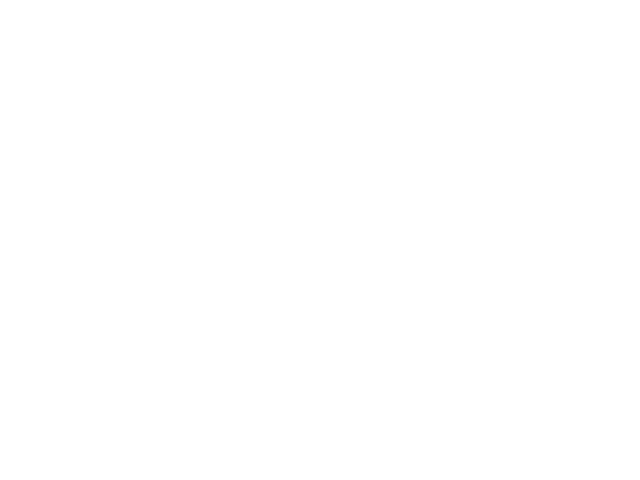

In [16]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= '%s_img_avg_run1'%uidstr,  save=True) 

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


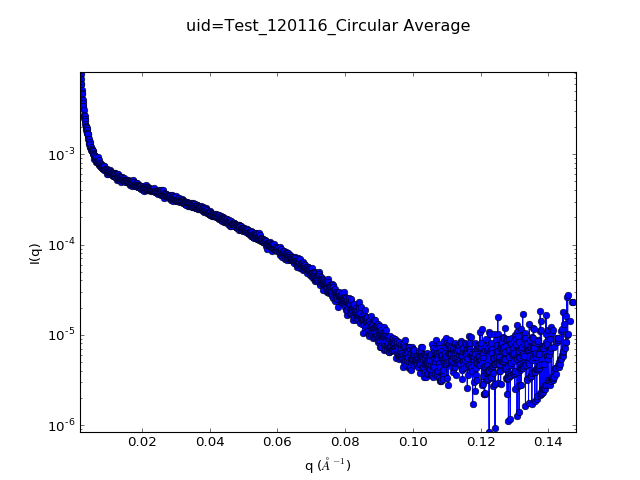

In [44]:
hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )

### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [18]:
uniformq = True #False

### Define a non-uniform distributed rings by giving edges

In [19]:
if not uniformq:    
    width = 0.0002    
    number_rings= 1    
    qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  qcenters, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [20]:
if uniformq:    
    inner_radius= 0.005 #0.005 for 50 nm, 0.006, #for 10nm/coralpor
    outer_radius = 0.04 #0.04 for 50 nm, 0.05, #for 10nm/coralpor 
    num_rings = 12
    gap_ring_number = 6
    width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
    edges = None

<IPython.core.display.Javascript object>


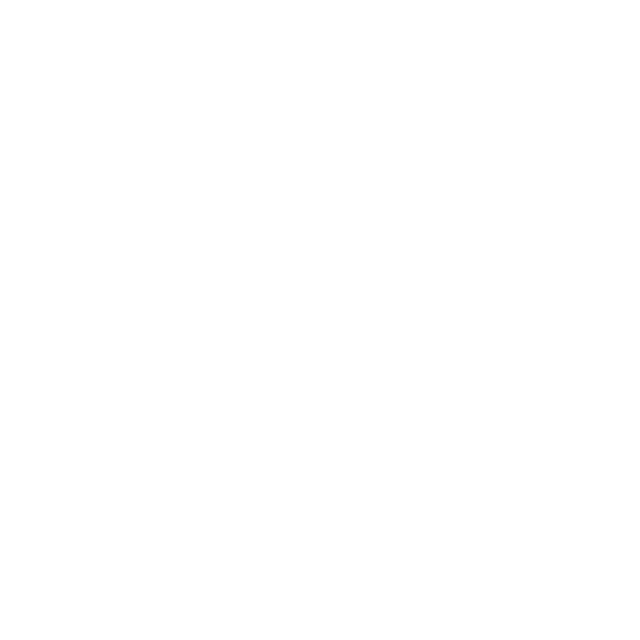

In [21]:
roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
qr = np.round( qr, 4)
show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 

qval_dict = get_qval_dict( np.round(qr, 4)  )  

<IPython.core.display.Javascript object>


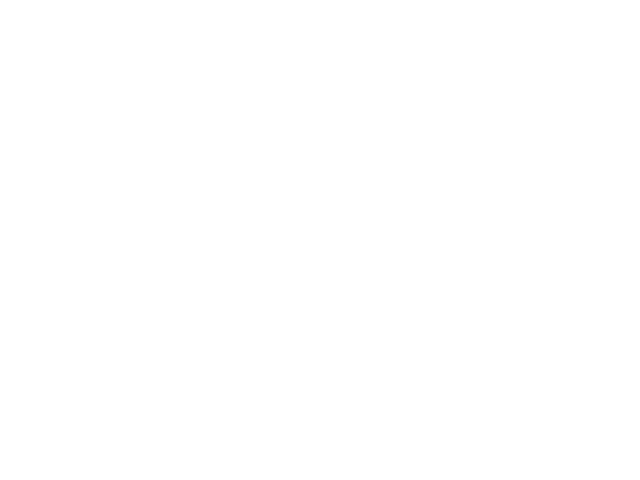

In [22]:
plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[q_saxs.min(), q_saxs.max()],
          ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)
#roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qth_interest, uid =uidstr, save=True, path=data_dir )


# Configure Multi-Run

## Control Multi-Runs Parameters


In [23]:
run_pargs=  dict(   
    force_compress =  force_compress,    #force to compress data 
    para_compress = para_compress,             #parallel compress
    run_fit_form = run_fit_form,             #run fit form factor  
    run_waterfall = run_waterfall,             #run waterfall analysis
    run_t_ROI_Inten = run_t_ROI_Inten,          #run  ROI intensity as a function of time
    run_one_time = run_one_time,      #run  one-time
    fit_g2_func = fit_g2_func,    
    run_two_time = run_two_time,    #run  two-time
    run_four_time = run_four_time,     #run  four-time
    run_xsvs=run_xsvs,            #run visibility analysis
    att_pdf_report = att_pdf_report,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  good_start,
    uniformq = uniformq,    inner_radius= inner_radius, 
    outer_radius =   outer_radius,    num_rings =num_rings,   gap_ring_number = gap_ring_number, 
    #number_rings= number_rings,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = use_sqnorm,  #if True, use sq to normalize intensity
    use_imgsum_norm=use_imgsum_norm,#if True use imgsum to normalize intensity for one-time calculatoin
    pdf_version = pdf_version #for pdf report name    
                )


# Do loop here

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/
****************************************
*****The processing uid is: 83a2889e*****
****************************************
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/
hdf5 path = /XF11ID/data/2016/12/01/76ae864d-821f-4c00-9bd0_2430_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
lambda_--> 1.28481
timeperframe--> 0.01
path--> /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/
Ldet--> 4889.99986649
exposuretime--> 2e-05
center--> [816, 1443]
dpix--> 0.0750000035623
uid--> uid=83a2889e


<IPython.core.display.Javascript object>


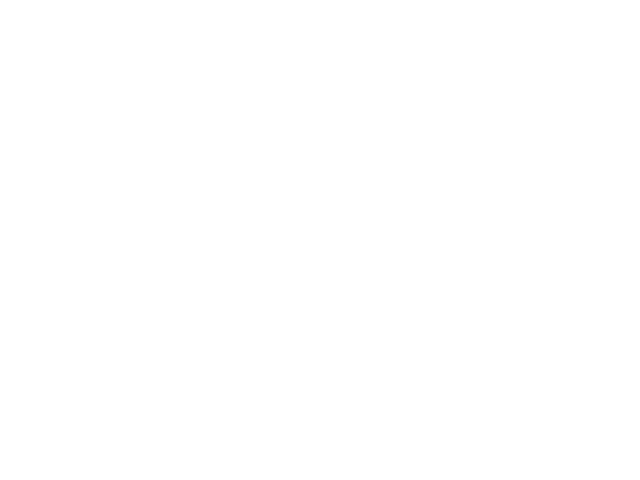

<IPython.core.display.Javascript object>


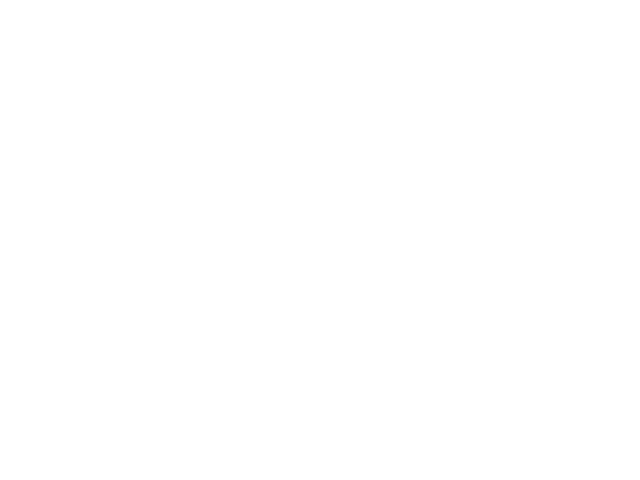

Averaging 497 images:   0%|          | 0/500 [00:00<?, ?it/s]

The non-zeros photon occupation is 0.0010801013890839536.
Will Always DO apply compress process.
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_83a2889e-4fb7-4643-9547-20af2f544507.cmp.
Bad frame list length is: 1


Averaging 497 images: 100%|██████████| 500/500 [00:00<00:00, 3298.73it/s]


The good_start frame number is: 5 
uid=83a2889e_fra_5_500


<IPython.core.display.Javascript object>


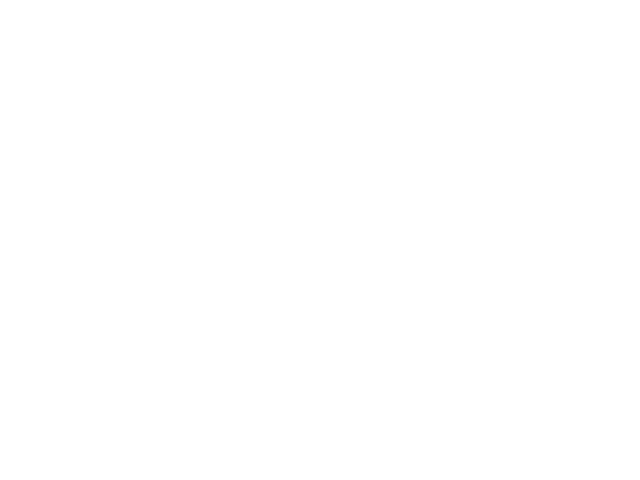

Total time: 0.01 min


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


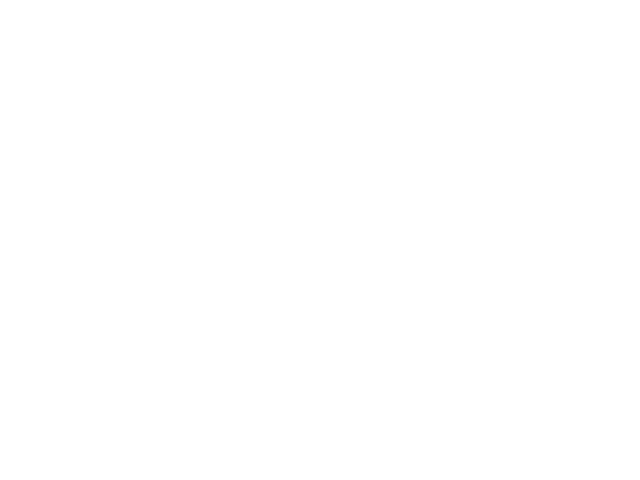

here
The bad frame list length is: 5


<IPython.core.display.Javascript object>


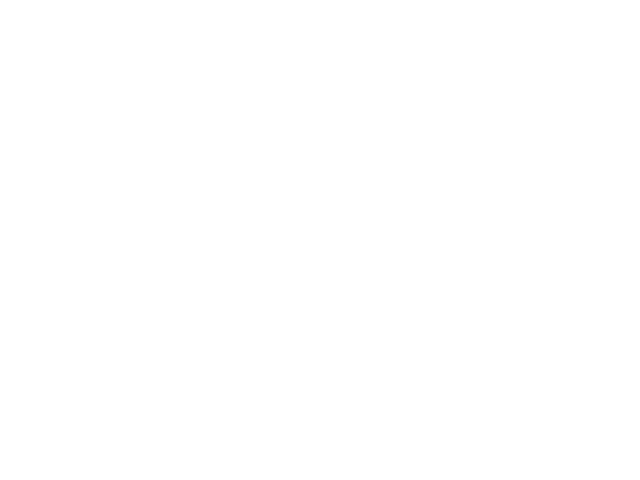

<IPython.core.display.Javascript object>


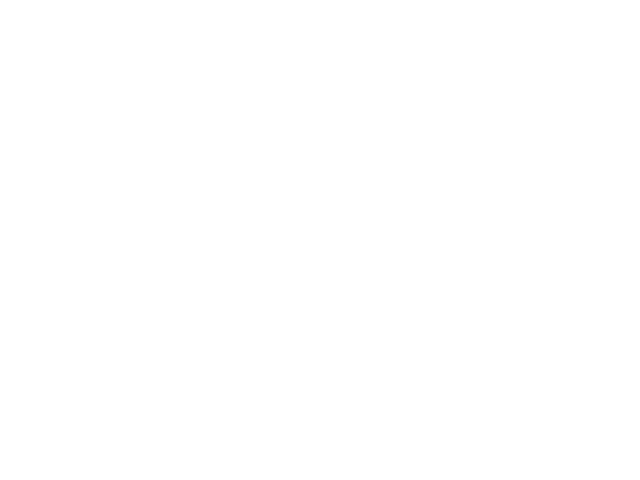

<IPython.core.display.Javascript object>


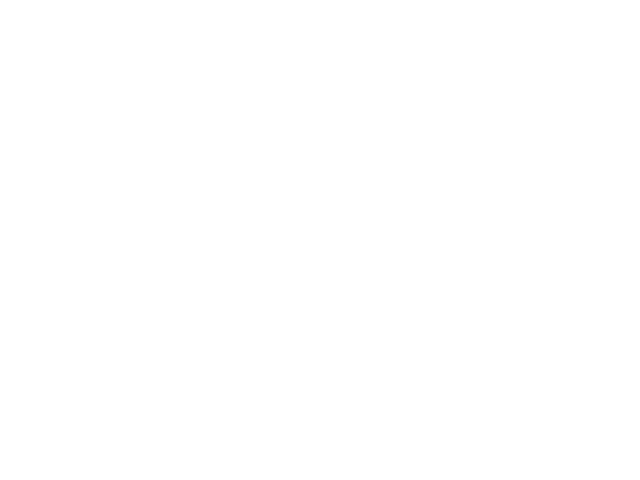

<IPython.core.display.Javascript object>


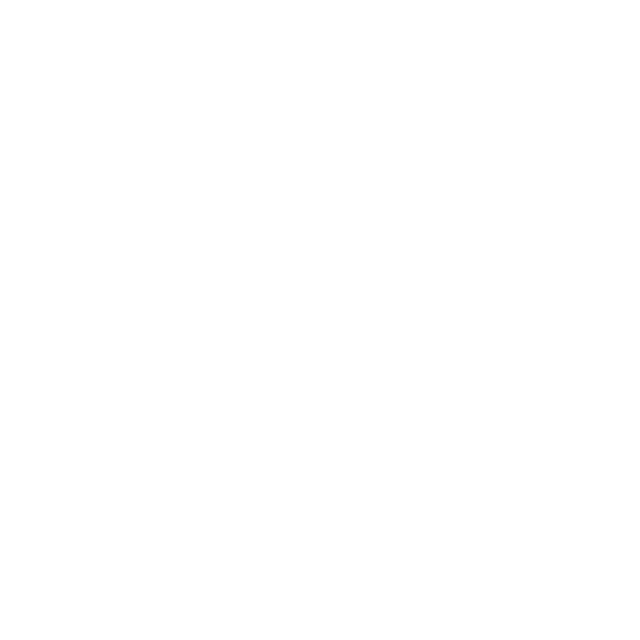

<IPython.core.display.Javascript object>


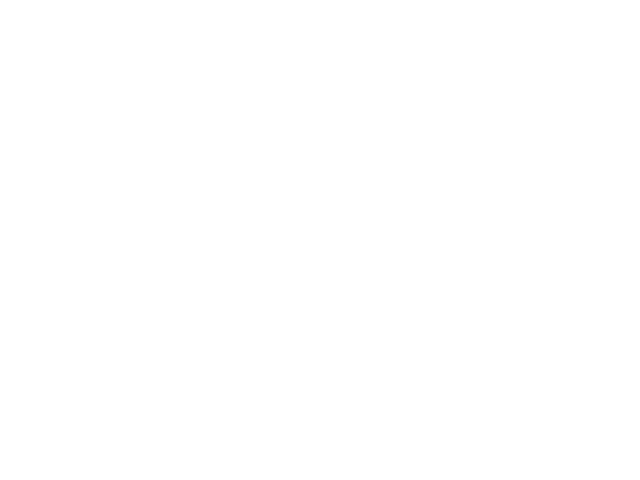

<IPython.core.display.Javascript object>


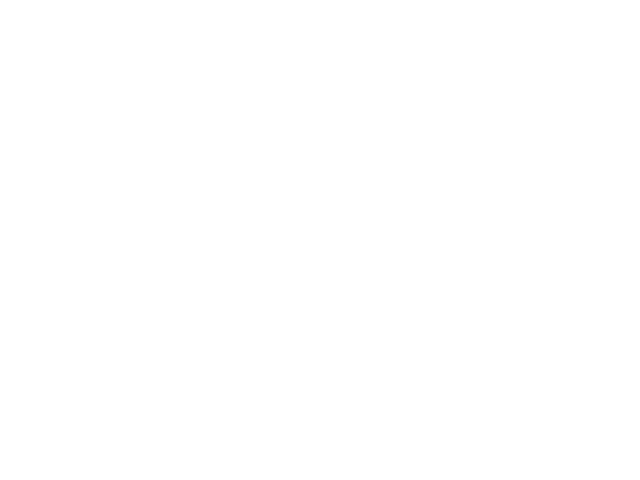

Averaging 997 images: 100%|██████████| 1/1 [00:00<00:00, 90.05it/s]


<IPython.core.display.Javascript object>


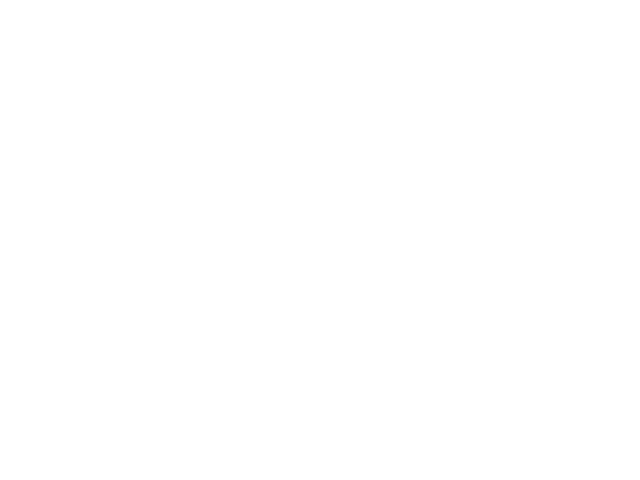

Get waterfall for q index=3:   0%|          | 0/495 [00:00<?, ?it/s]

The file: uid=83a2889e_q_Iqt is saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/


Get waterfall for q index=3: 100%|██████████| 495/495 [00:00<00:00, 6531.31it/s]


<IPython.core.display.Javascript object>


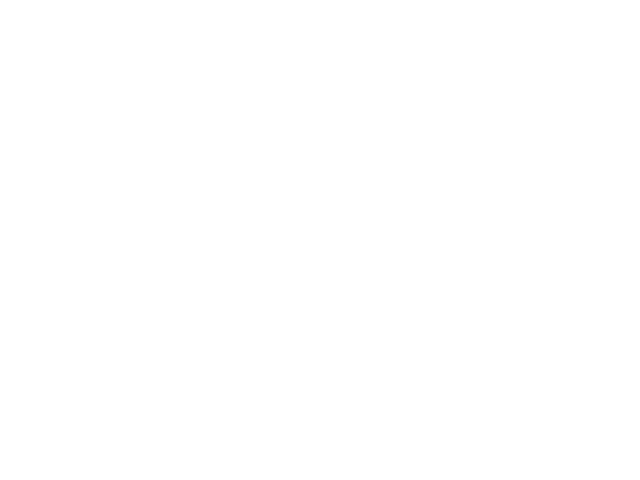

Get ROI intensity of each frame: 100%|██████████| 495/495 [00:00<00:00, 10393.48it/s]


<IPython.core.display.Javascript object>


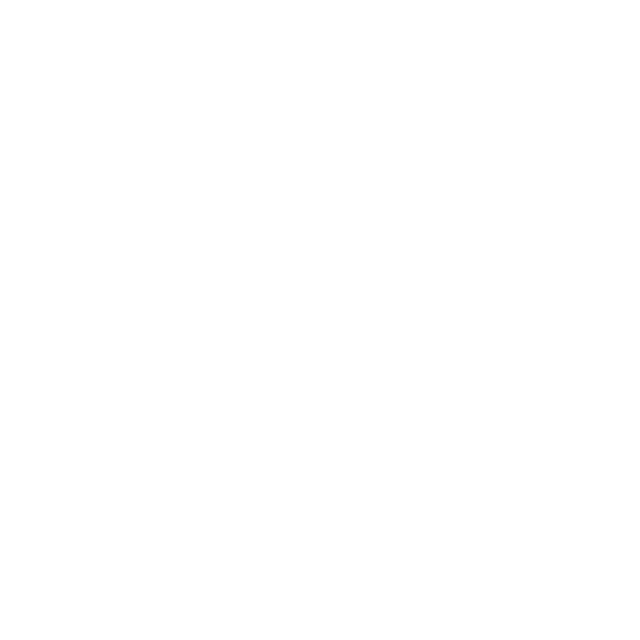

The file: uid=83a2889e_t_ROIs is saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/
In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
496 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:06<00:00,  1.43it/s]

G2 calculation DONE!
Total time: 0.18 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/ with filename as uid=83a2889e_fra_5_500_g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/uid=83a2889e_fra_5_500_g2_fit_paras.csv


<IPython.core.display.Javascript object>


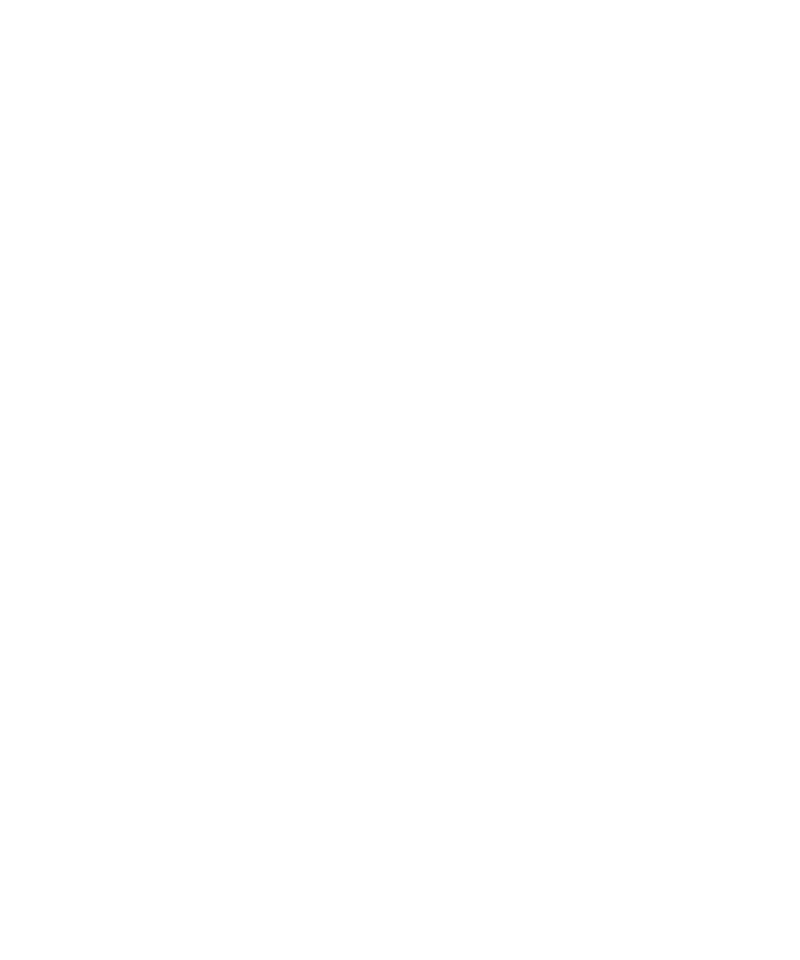

The fitted diffusion coefficient D0 is:  2.419e+05   A^2S-1


<IPython.core.display.Javascript object>


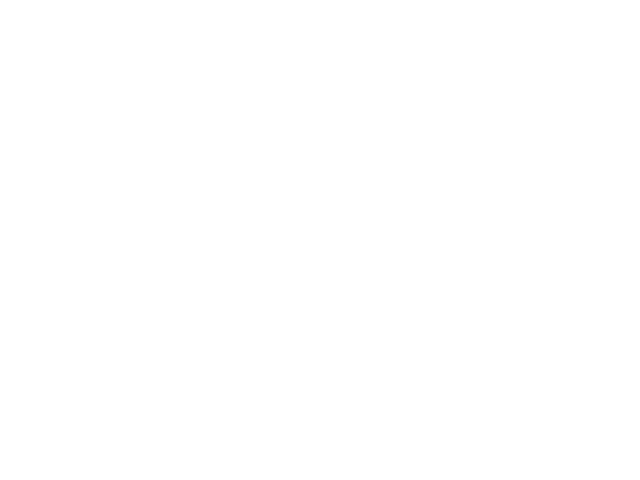

100%|██████████| 12/12 [00:05<00:00,  1.62it/s]

Total time: 0.09 min


<IPython.core.display.Javascript object>


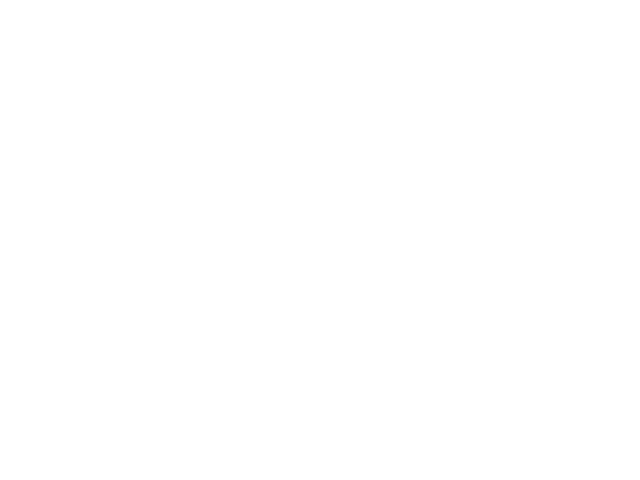

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/ with filename as uid=83a2889e_fra_5_500_g2b.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/uid=83a2889e_fra_5_500_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


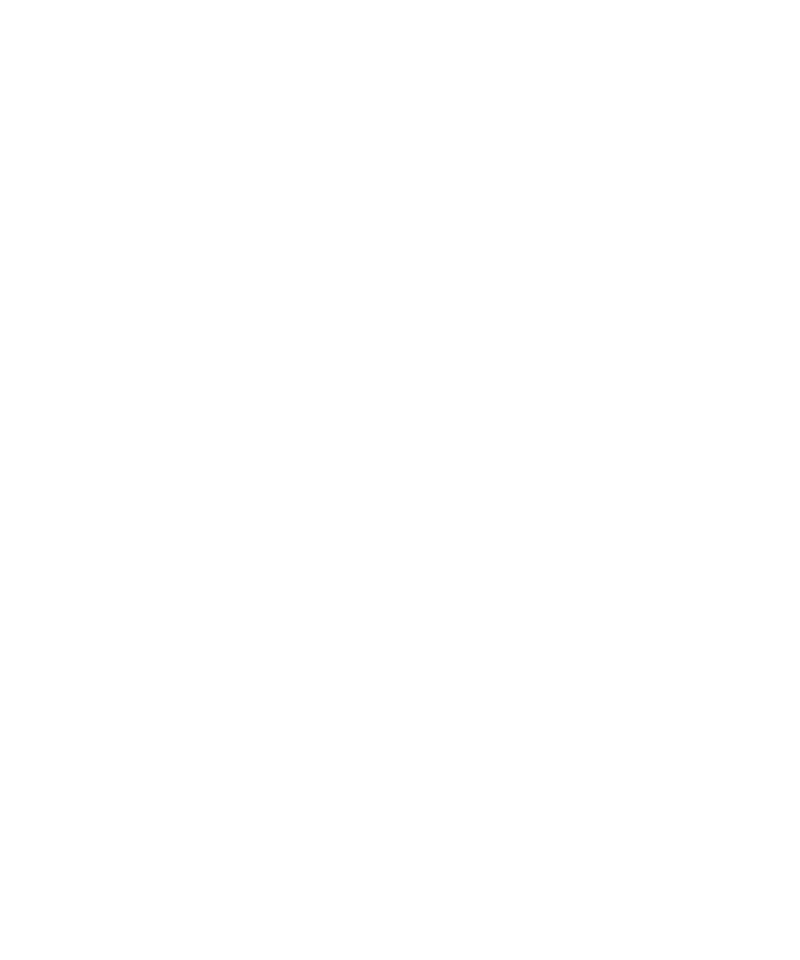

<IPython.core.display.Javascript object>


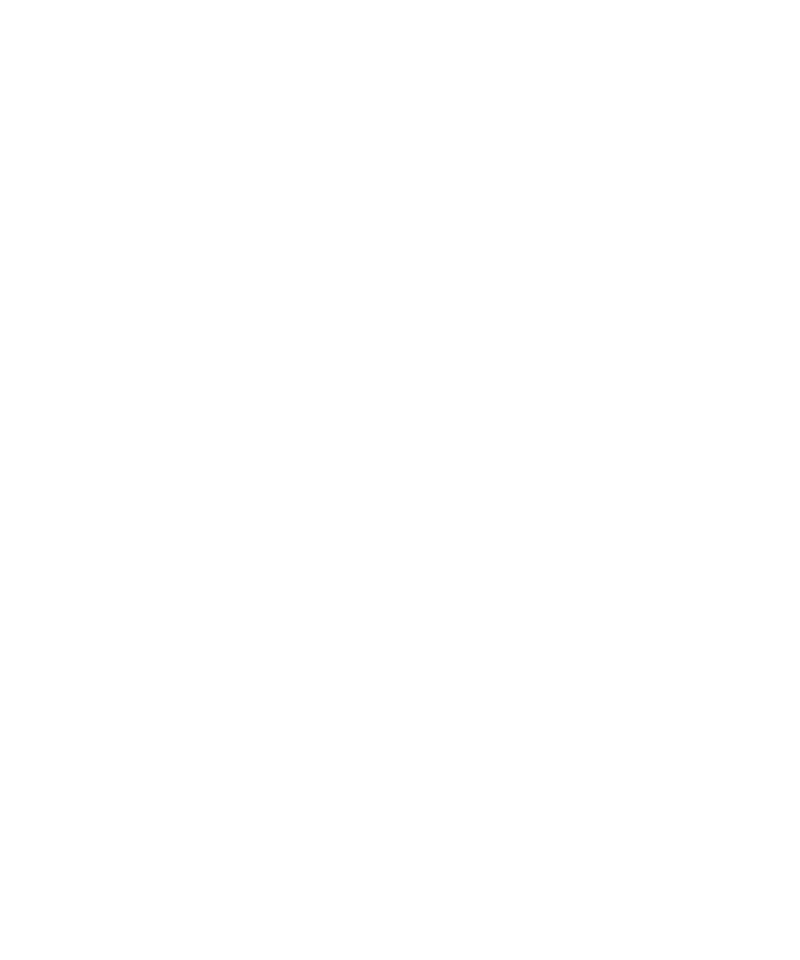

Get max intensity of ROIs in all frames: 100%|██████████| 495/495 [00:00<00:00, 12019.87it/s]


The max counts are: 3


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


 42%|████▏     | 5/12 [00:00<00:00, 37.60it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


Histogram calculation DONE!
Total time: 0.11 min
The file: uid=83a2889e_fra_5_500_spec_res.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/
The difference sum of average photon counts between fit and data are: 0.0
##############################
The fitted M for Qth= 10 are: [0.01055662297472218, 0.020886195273711054]
0.000262017280513
##############################


<IPython.core.display.Javascript object>


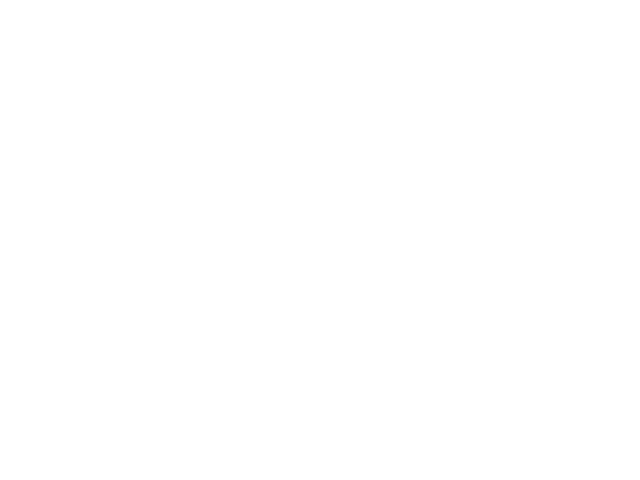

<IPython.core.display.Javascript object>


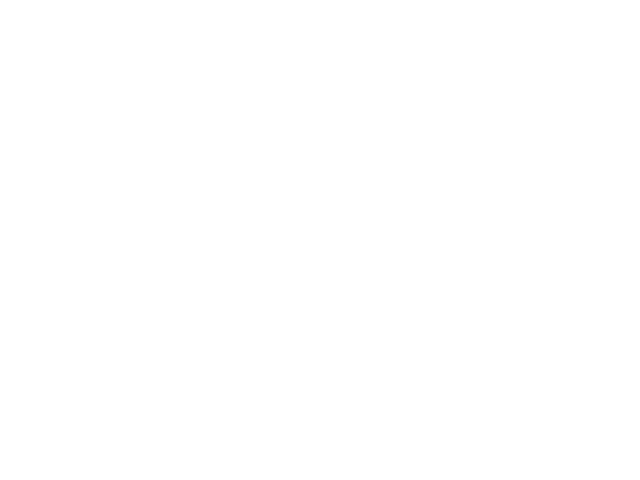

The K-M values are saved as uid=83a2889e_fra_5_500_xsvs_fitted_KM.csv in /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/.


<IPython.core.display.Javascript object>


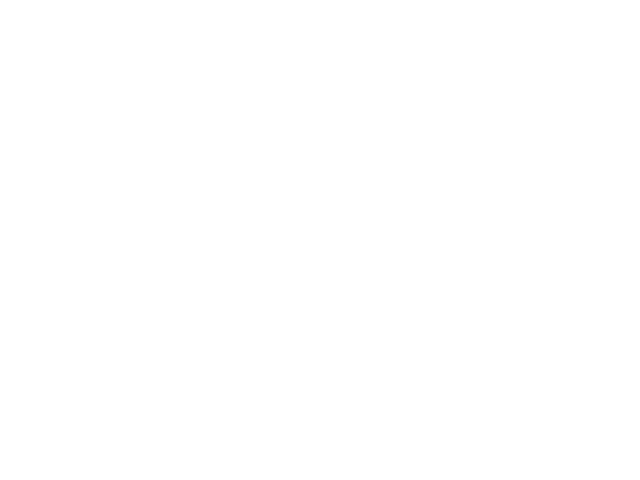

<IPython.core.display.Javascript object>


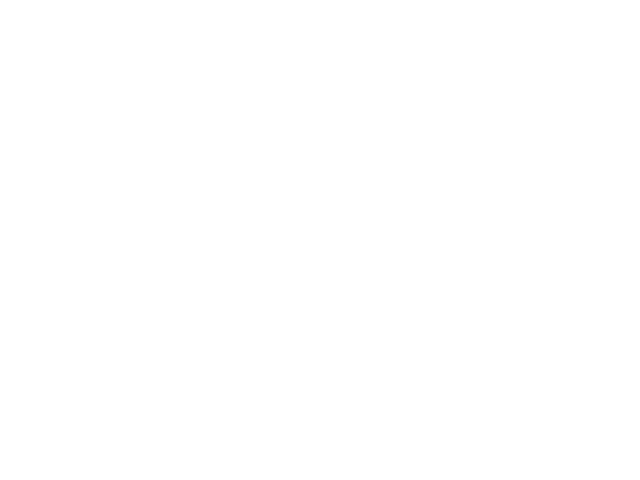

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/83a2889e/ with filename as uid=83a2889e-4fb7-4643-9547-20af2f544507_Res.h5

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=83a2889e_1.pdf
****************************************
I can't attach this PDF: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=83a2889e_1.pdf due to a duplicated filename. Please give a different PDF file.
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/
****************************************
*****The processing uid is: 15de40bd*****
****************************************
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/
hdf5 path = /XF11ID/data/2016/12/01/28e180f0-9c70-4979-890c_2431_master.h5
The data are: Sliced and/or processed F

<IPython.core.display.Javascript object>


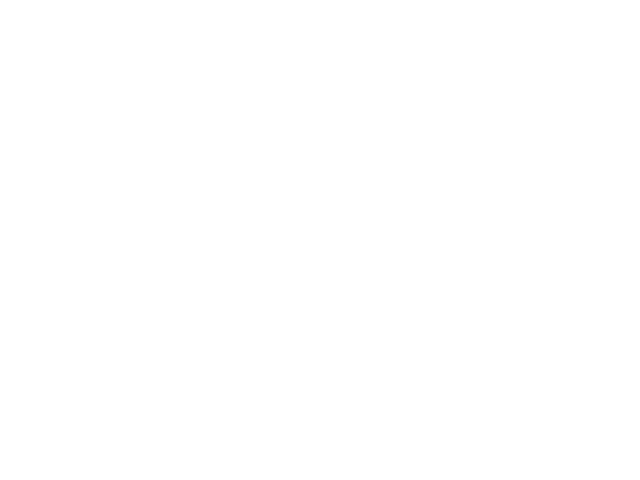

<IPython.core.display.Javascript object>


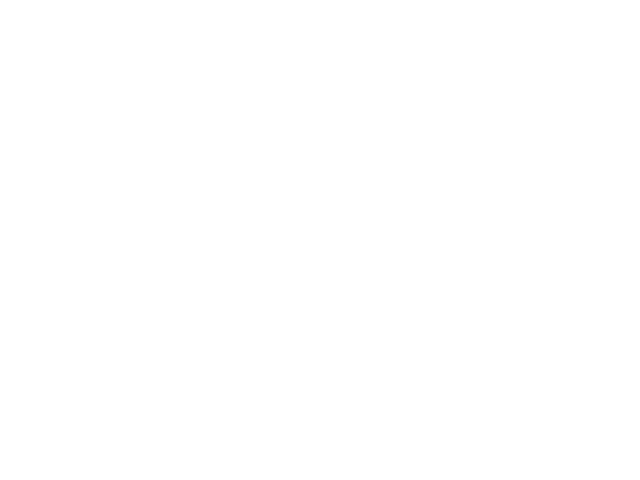

Averaging 497 images:  58%|█████▊    | 289/500 [00:00<00:00, 2888.10it/s]

The non-zeros photon occupation is 0.001121566581729901.
Will Always DO apply compress process.
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_15de40bd-ac4b-4fca-93b6-45283578454c.cmp.
Bad frame list length is: 1


Averaging 497 images: 100%|██████████| 500/500 [00:00<00:00, 3255.85it/s]

The good_start frame number is: 5 
uid=15de40bd_fra_5_500


<IPython.core.display.Javascript object>


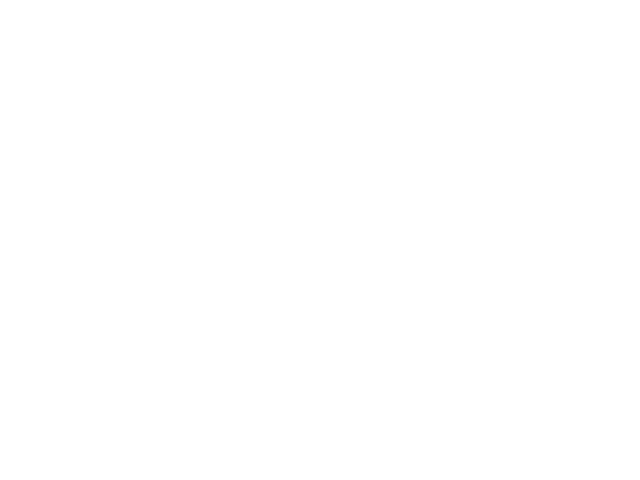

Total time: 0.01 min


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


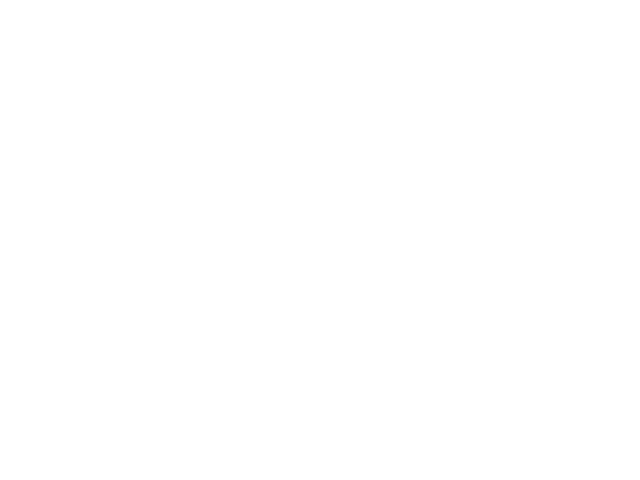

here
The bad frame list length is: 5


<IPython.core.display.Javascript object>


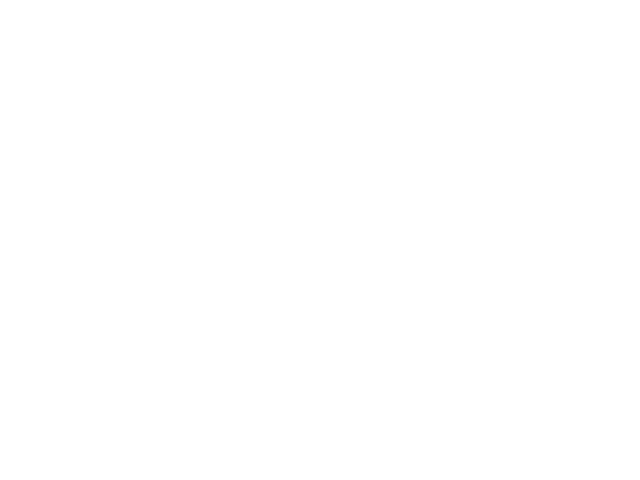

<IPython.core.display.Javascript object>


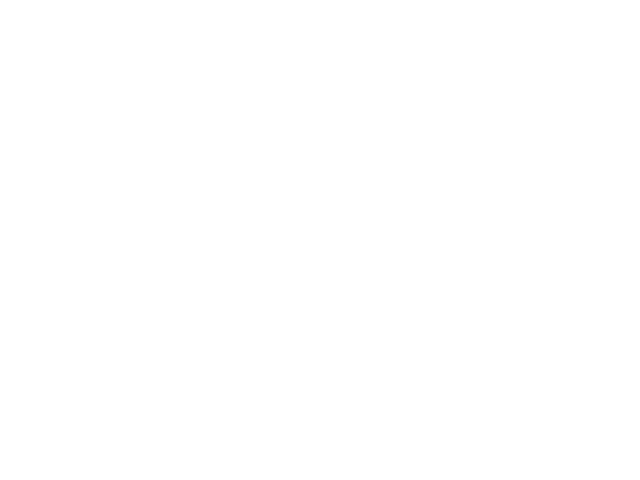

<IPython.core.display.Javascript object>


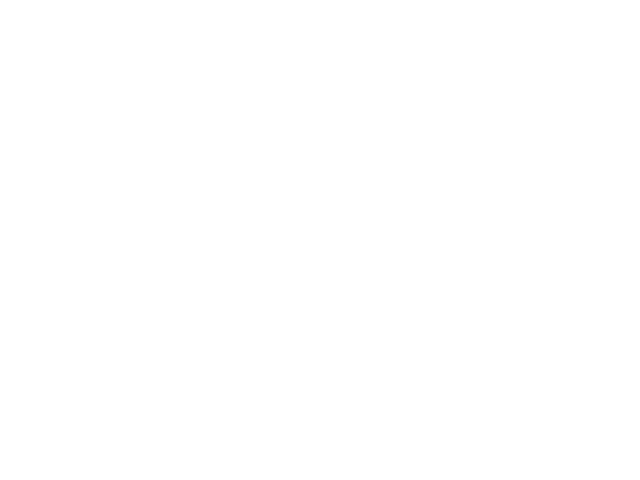

<IPython.core.display.Javascript object>


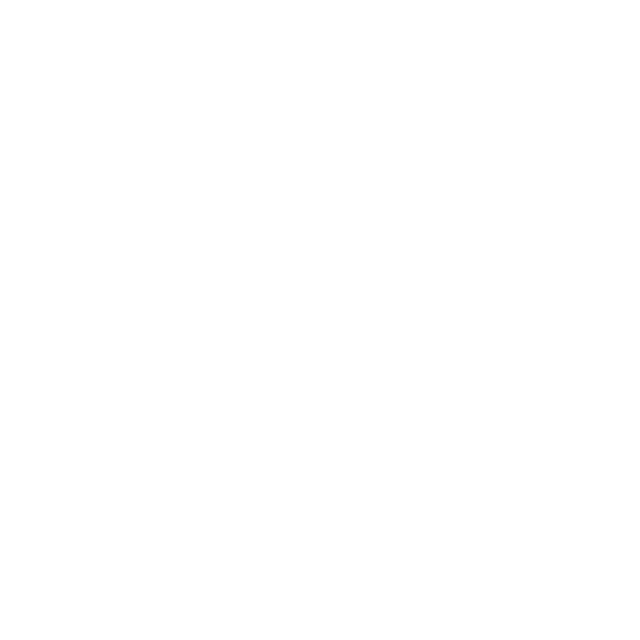

<IPython.core.display.Javascript object>


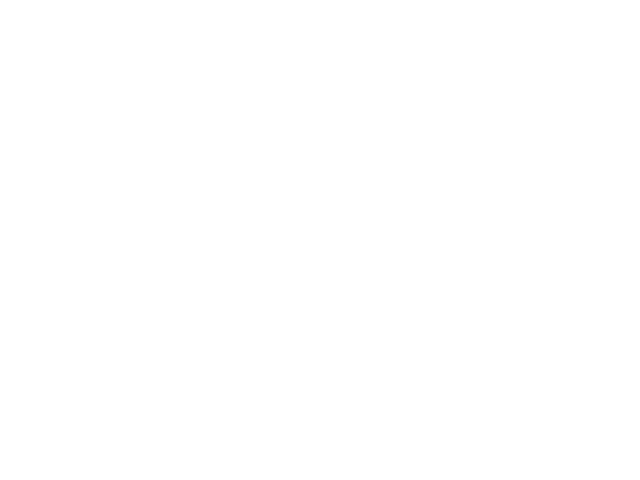

<IPython.core.display.Javascript object>


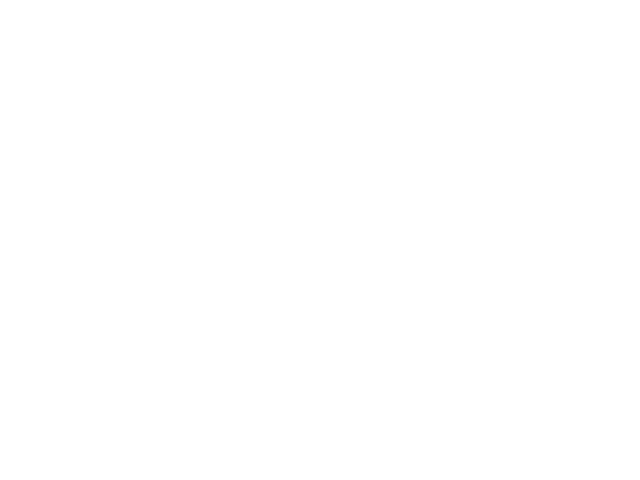

Averaging 997 images: 100%|██████████| 1/1 [00:00<00:00, 92.82it/s]


<IPython.core.display.Javascript object>


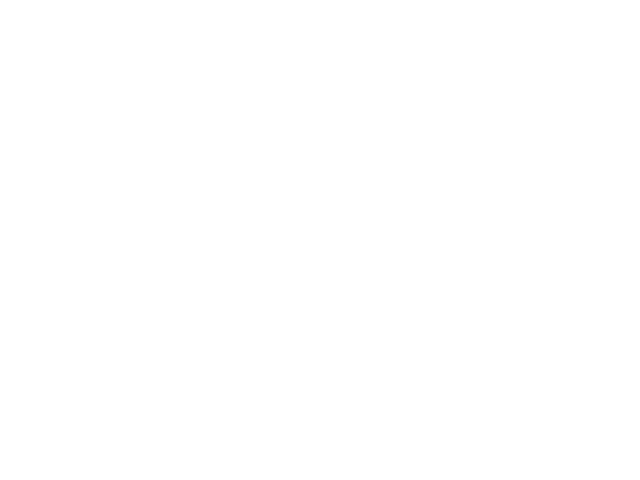

Get waterfall for q index=3: 100%|██████████| 495/495 [00:00<00:00, 6465.43it/s]

The file: uid=15de40bd_q_Iqt is saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/


<IPython.core.display.Javascript object>


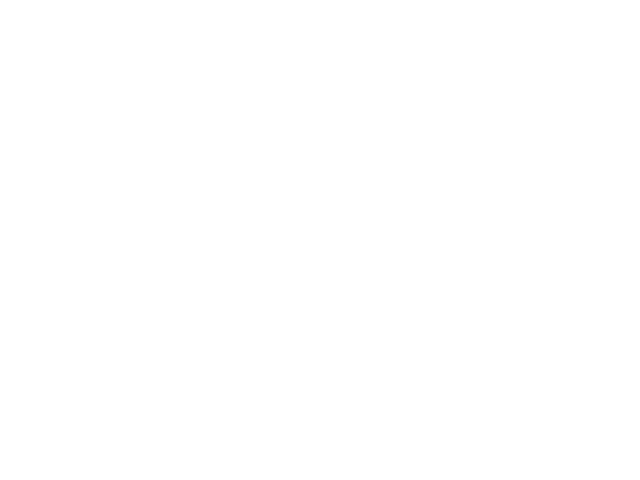

Get ROI intensity of each frame: 100%|██████████| 495/495 [00:00<00:00, 10241.26it/s]


<IPython.core.display.Javascript object>


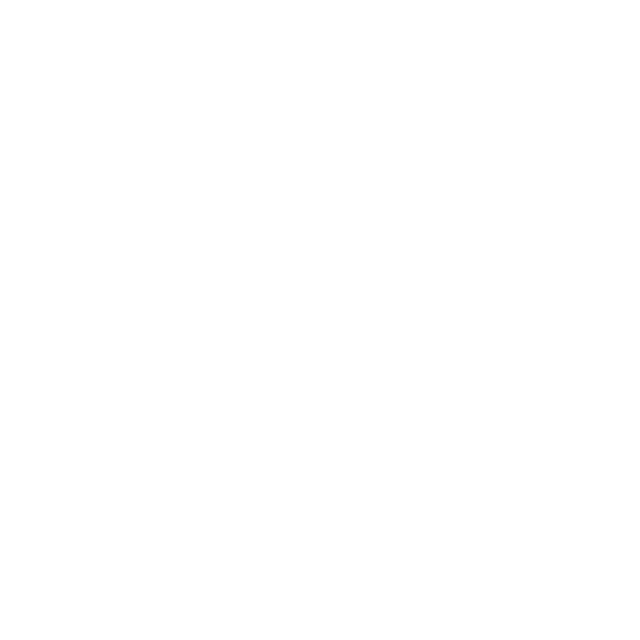

The file: uid=15de40bd_t_ROIs is saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/
In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
496 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:06<00:00,  1.55it/s]


G2 calculation DONE!
Total time: 0.19 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/ with filename as uid=15de40bd_fra_5_500_g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/uid=15de40bd_fra_5_500_g2_fit_paras.csv


<IPython.core.display.Javascript object>


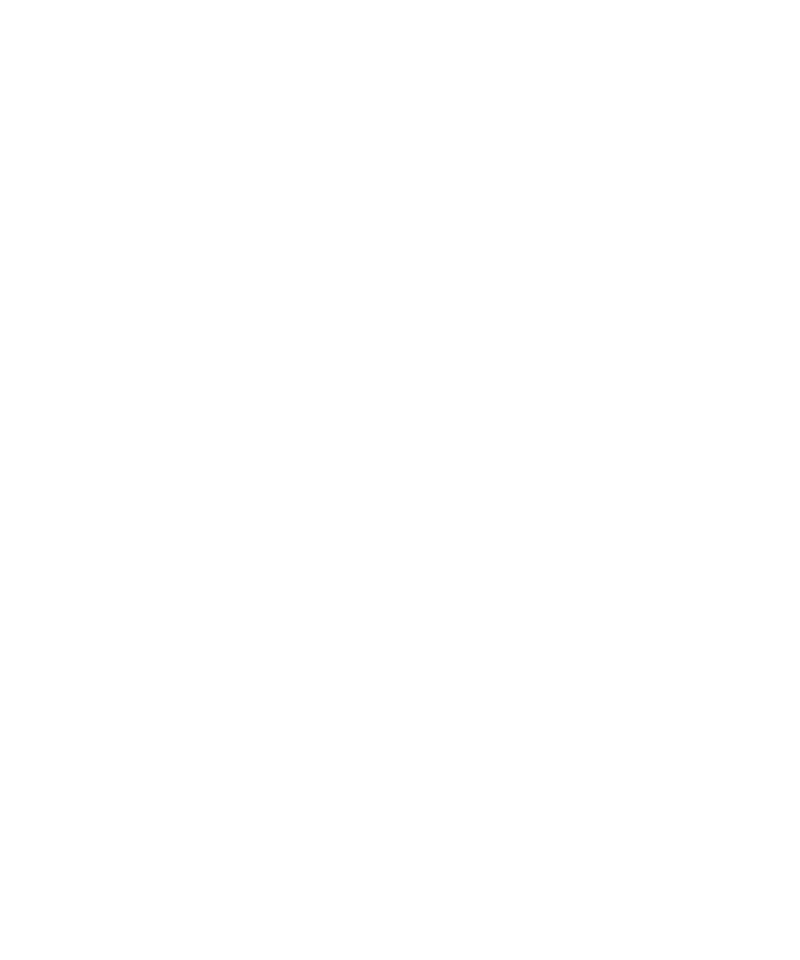

The fitted diffusion coefficient D0 is:  1.782e+05   A^2S-1


<IPython.core.display.Javascript object>


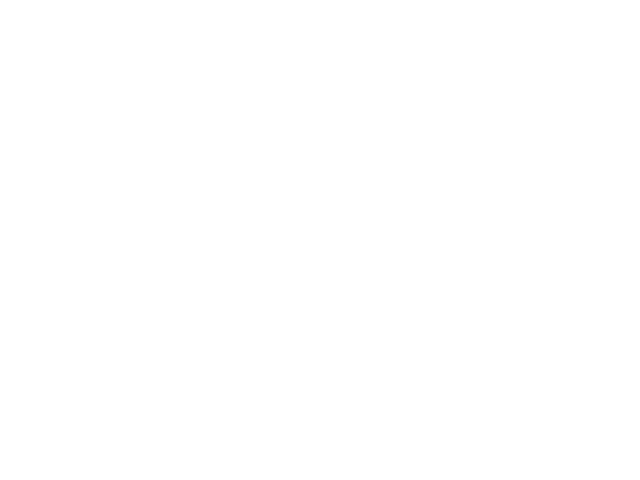

100%|██████████| 12/12 [00:05<00:00,  1.58it/s]

Total time: 0.09 min


<IPython.core.display.Javascript object>


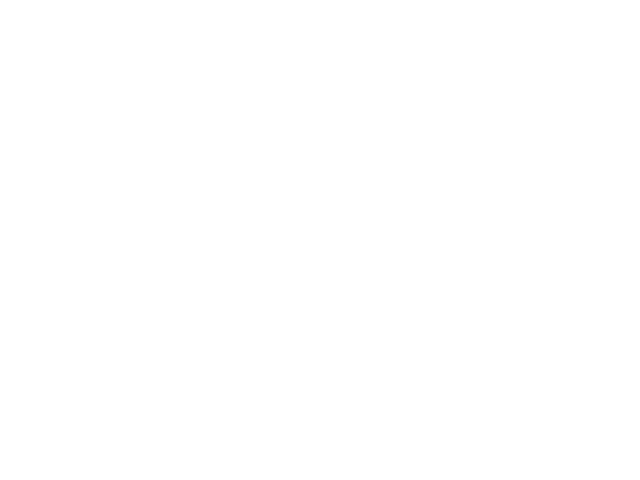

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/ with filename as uid=15de40bd_fra_5_500_g2b.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/uid=15de40bd_fra_5_500_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


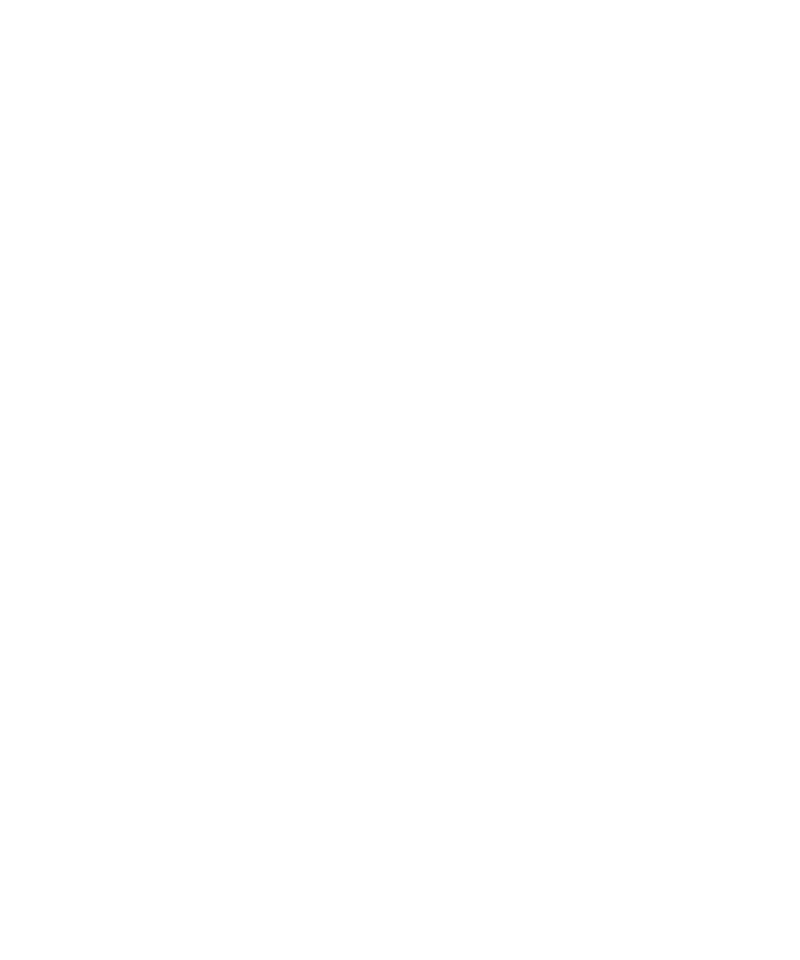

<IPython.core.display.Javascript object>


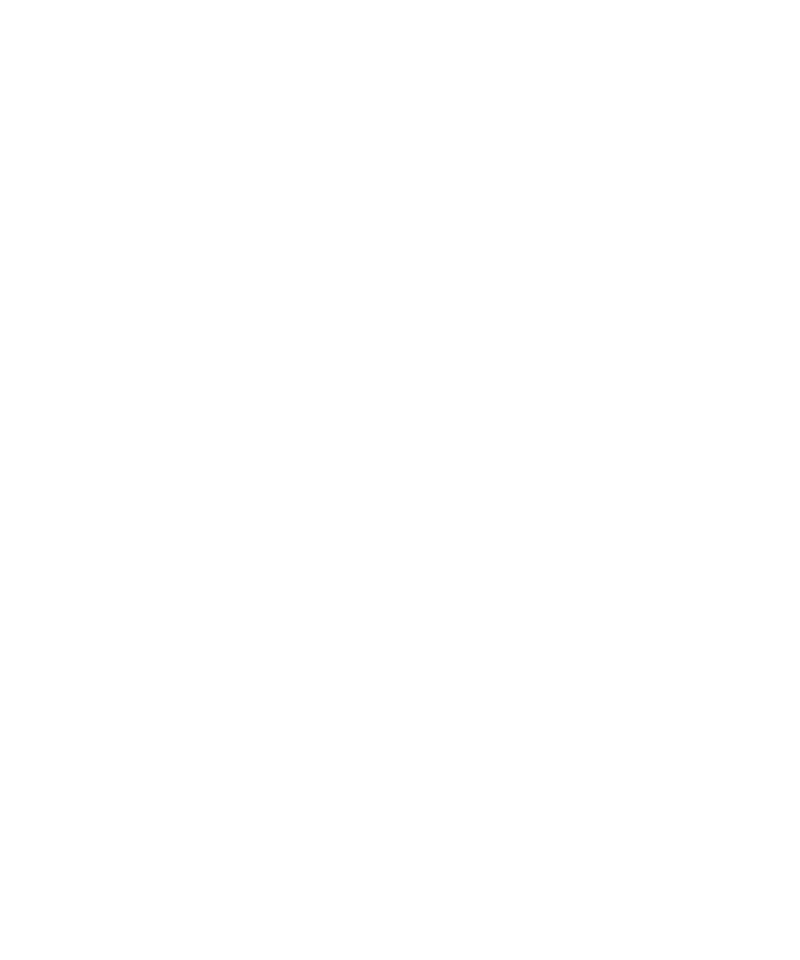

Get max intensity of ROIs in all frames: 100%|██████████| 495/495 [00:00<00:00, 12004.86it/s]


The max counts are: 3


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:02<00:00,  3.70it/s]


Histogram calculation DONE!
Total time: 0.12 min
The file: uid=15de40bd_fra_5_500_spec_res.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/
The difference sum of average photon counts between fit and data are: 0.0
##############################
The fitted M for Qth= 10 are: [0.0084293415525322768, 0.0168394659277709]
0.000263423506882
##############################


<IPython.core.display.Javascript object>


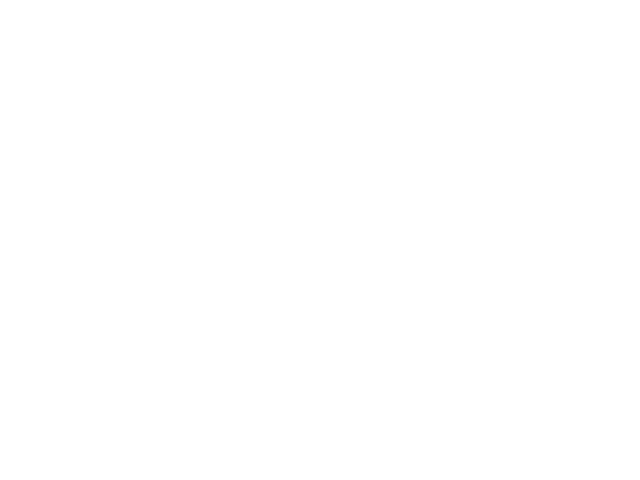

<IPython.core.display.Javascript object>


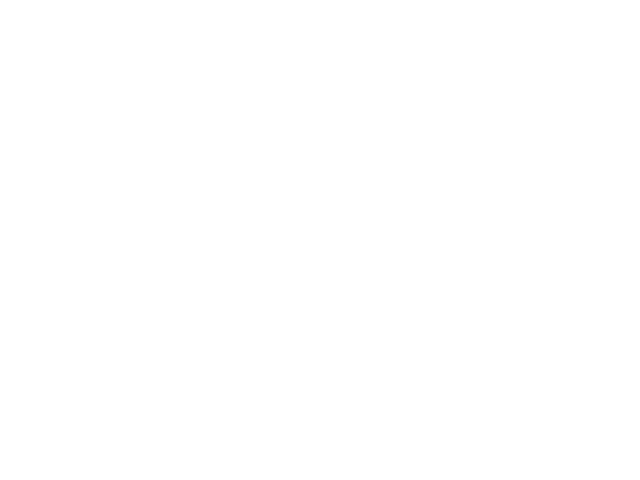

The K-M values are saved as uid=15de40bd_fra_5_500_xsvs_fitted_KM.csv in /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/.


<IPython.core.display.Javascript object>


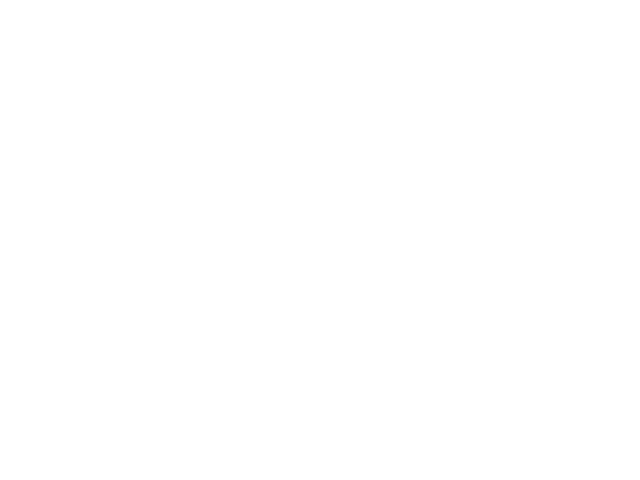

<IPython.core.display.Javascript object>


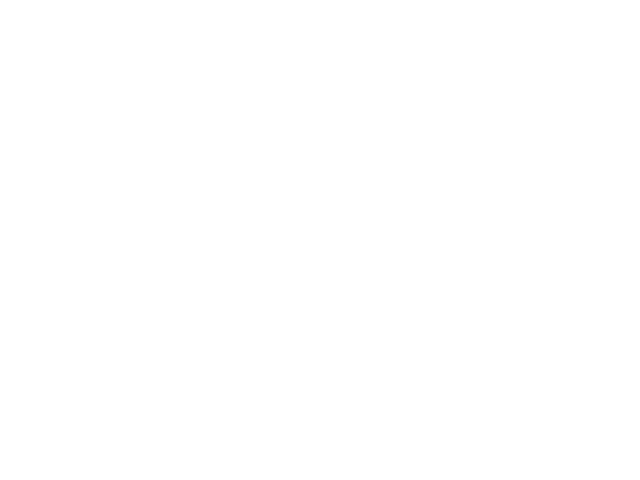

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/15de40bd/ with filename as uid=15de40bd-ac4b-4fca-93b6-45283578454c_Res.h5

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=15de40bd_1.pdf
****************************************
I can't attach this PDF: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=15de40bd_1.pdf due to a duplicated filename. Please give a different PDF file.
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/
****************************************
*****The processing uid is: 5d1e13a7*****
****************************************
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/
hdf5 path = /XF11ID/data/2016/12/01/b3bc38f7-84d5-45c7-8800_2432_master.h5
The data are: Sliced and/or processed F

<IPython.core.display.Javascript object>


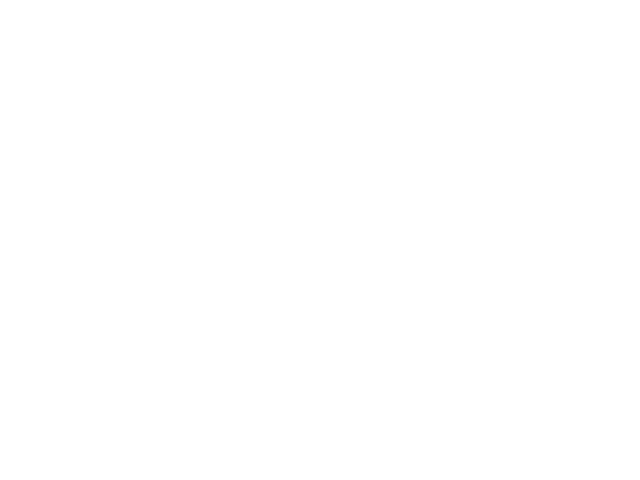

<IPython.core.display.Javascript object>


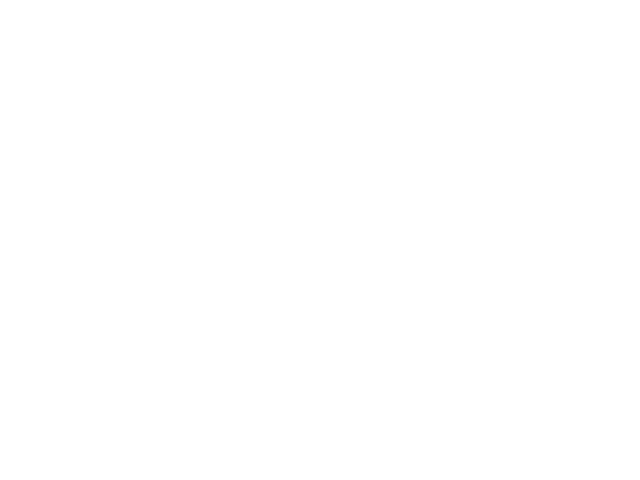

Averaging 497 images:   0%|          | 0/500 [00:00<?, ?it/s]

The non-zeros photon occupation is 0.0011037320902692784.
Will Always DO apply compress process.
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_5d1e13a7-2c47-4869-b280-d69323a6ab85.cmp.
Bad frame list length is: 1


Averaging 497 images: 100%|██████████| 500/500 [00:00<00:00, 3159.79it/s]


The good_start frame number is: 5 
uid=5d1e13a7_fra_5_500


<IPython.core.display.Javascript object>


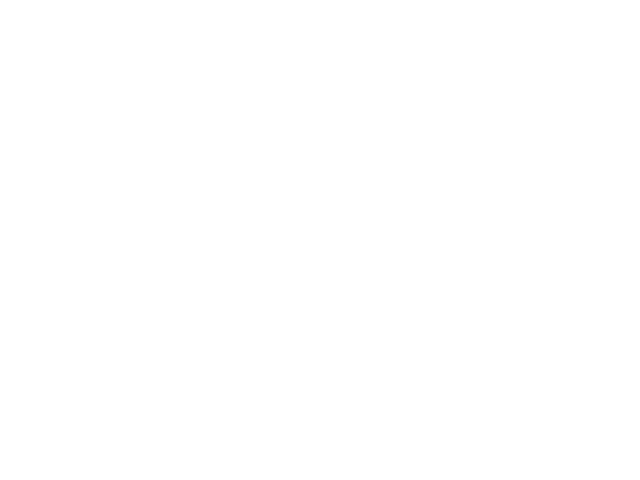

Total time: 0.01 min


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


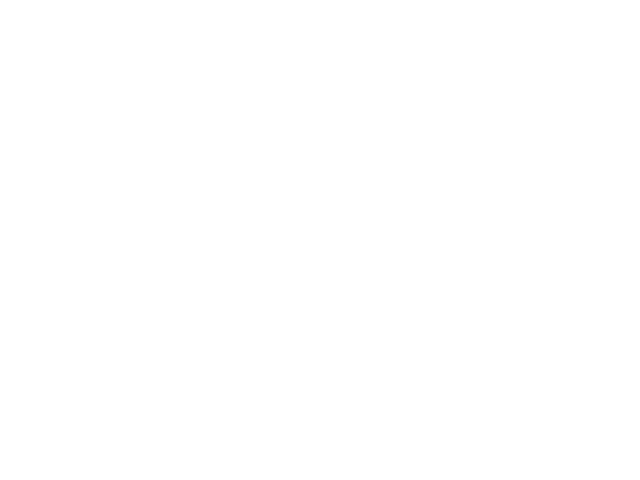

here
The bad frame list length is: 5


<IPython.core.display.Javascript object>


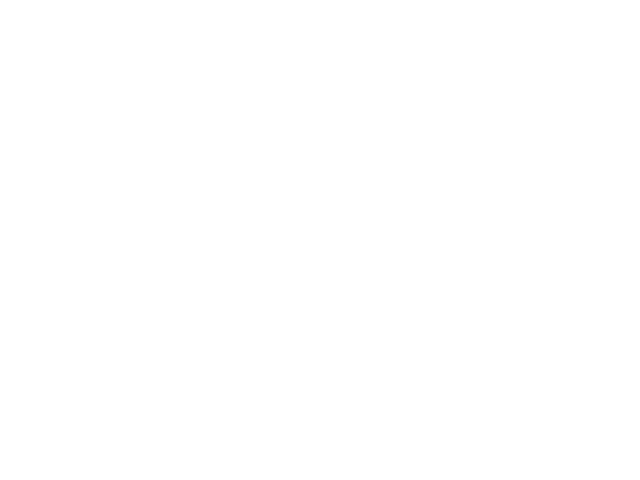

<IPython.core.display.Javascript object>


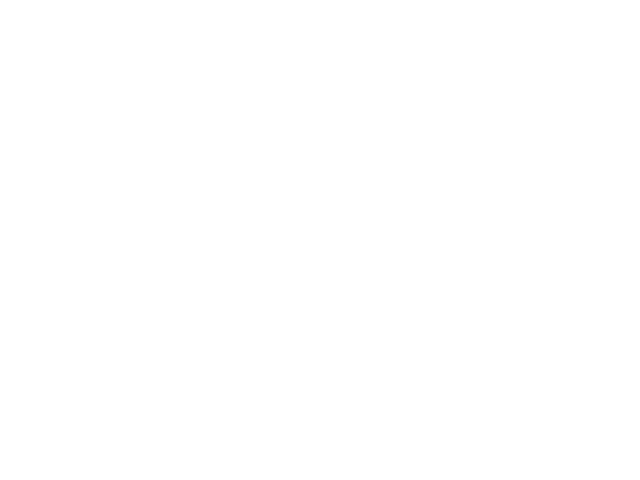

<IPython.core.display.Javascript object>


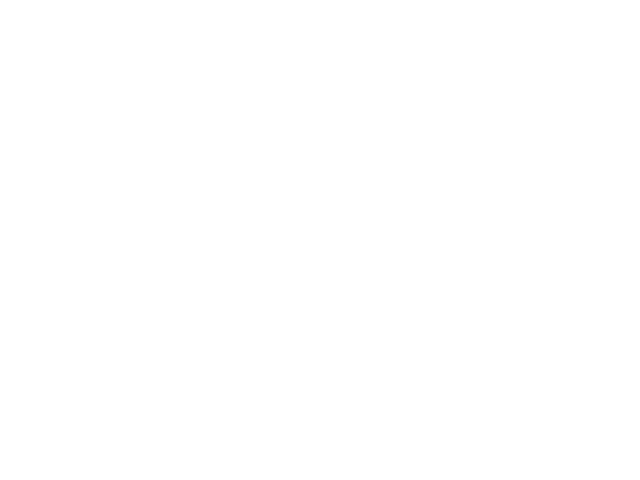

<IPython.core.display.Javascript object>


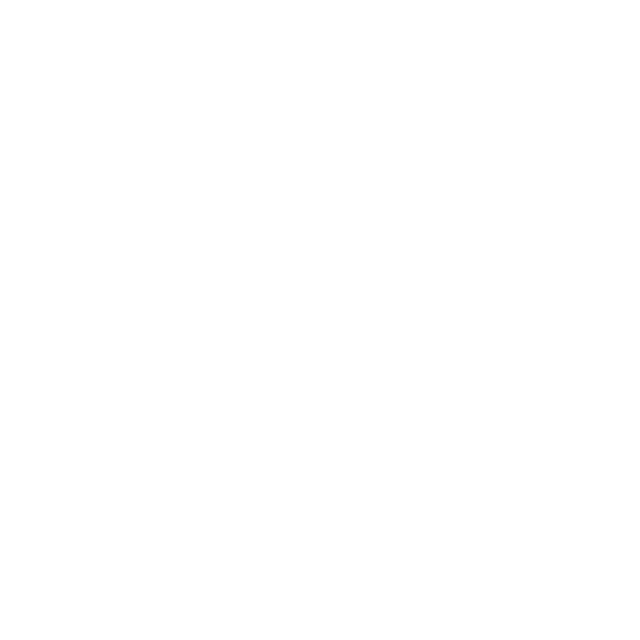

<IPython.core.display.Javascript object>


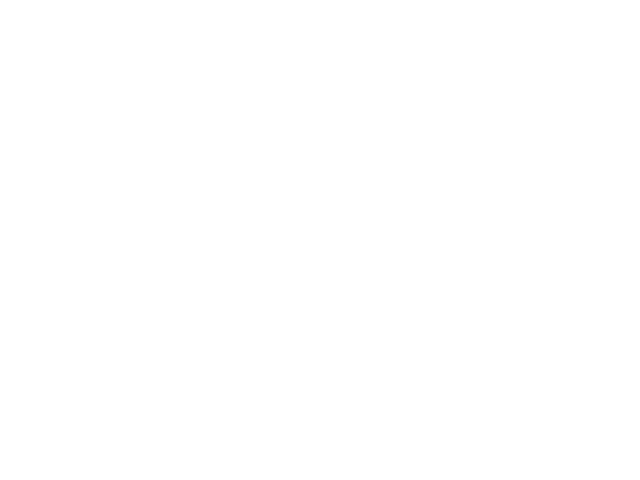

<IPython.core.display.Javascript object>


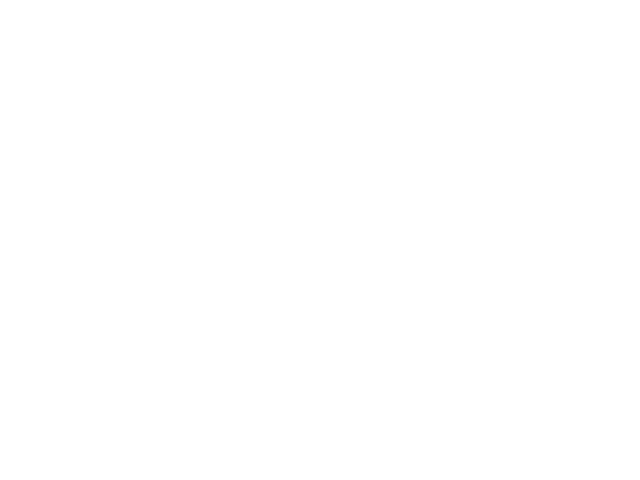

Averaging 997 images: 100%|██████████| 1/1 [00:00<00:00, 97.49it/s]


<IPython.core.display.Javascript object>


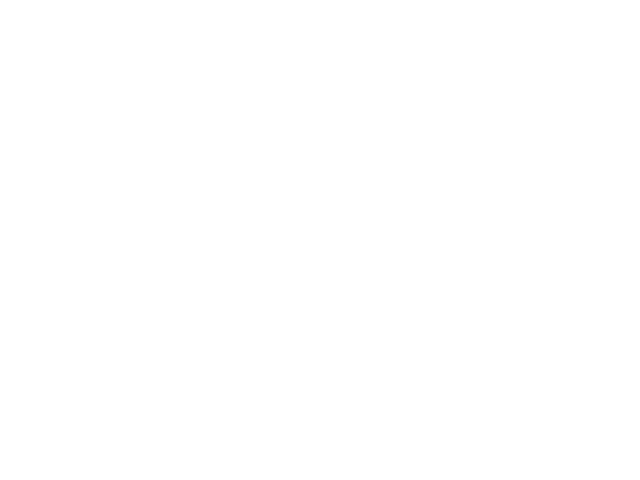

Get waterfall for q index=3:   0%|          | 0/495 [00:00<?, ?it/s]

The file: uid=5d1e13a7_q_Iqt is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/


Get waterfall for q index=3: 100%|██████████| 495/495 [00:00<00:00, 6761.55it/s]


<IPython.core.display.Javascript object>


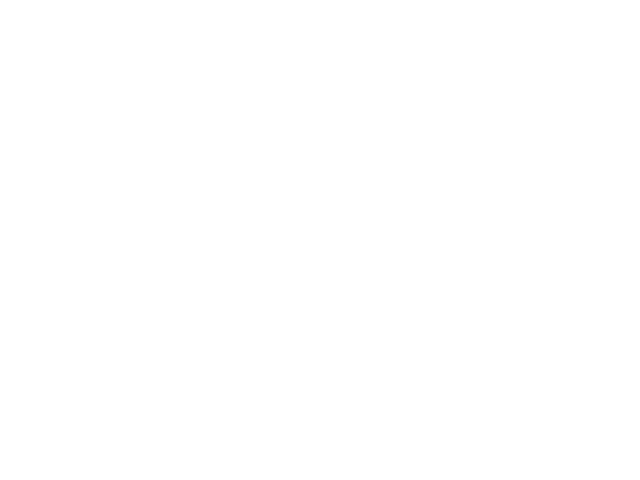

Get ROI intensity of each frame: 100%|██████████| 495/495 [00:00<00:00, 10914.28it/s]


<IPython.core.display.Javascript object>


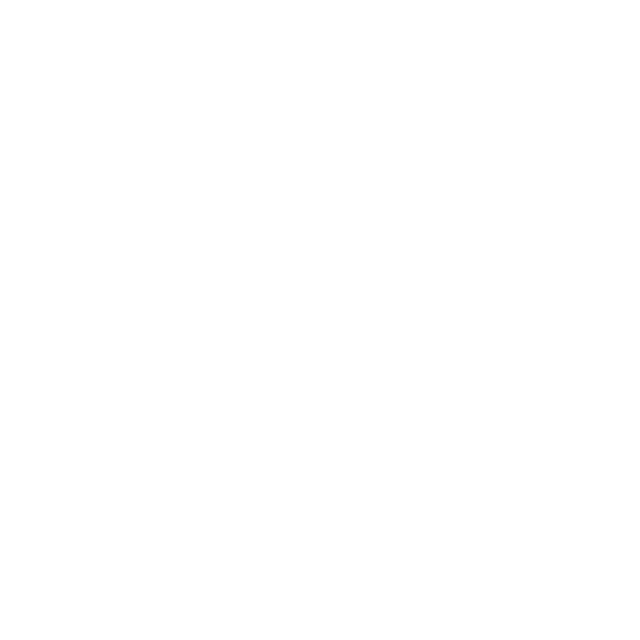

The file: uid=5d1e13a7_t_ROIs is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/
In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
496 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:06<00:00,  1.62it/s]


G2 calculation DONE!
Total time: 0.18 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/ with filename as uid=5d1e13a7_fra_5_500_g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/uid=5d1e13a7_fra_5_500_g2_fit_paras.csv


<IPython.core.display.Javascript object>


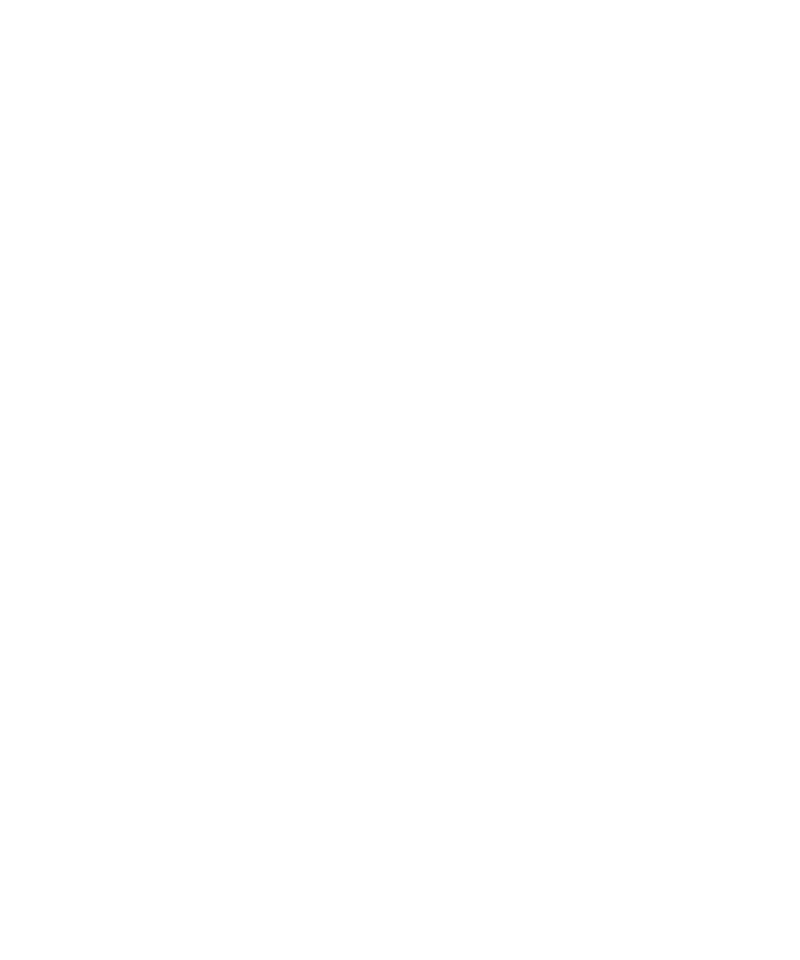

The fitted diffusion coefficient D0 is:  5.125e+04   A^2S-1


<IPython.core.display.Javascript object>


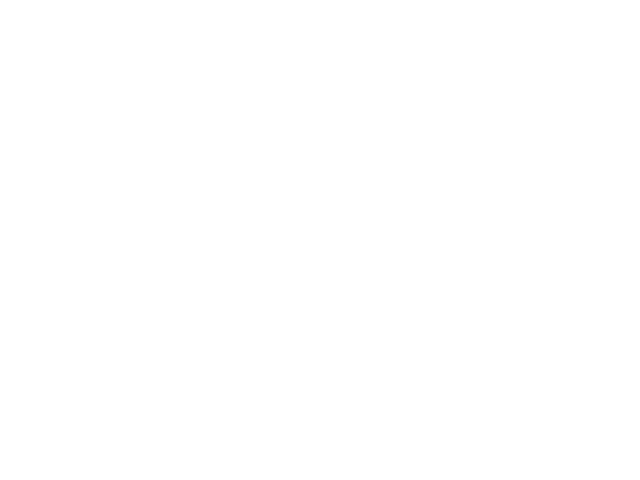

100%|██████████| 12/12 [00:05<00:00,  1.59it/s]

Total time: 0.09 min


<IPython.core.display.Javascript object>


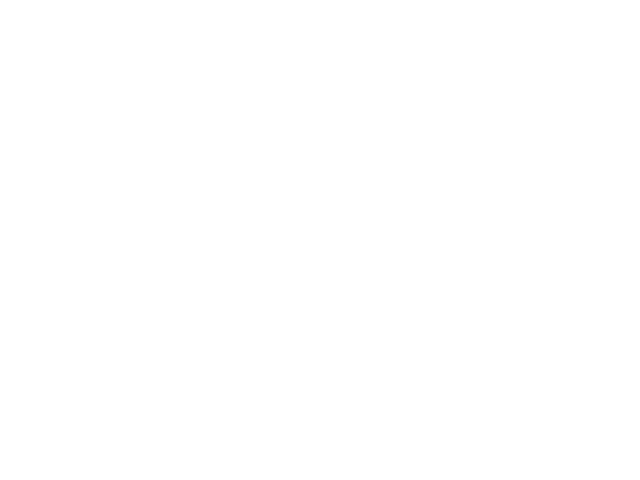

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/ with filename as uid=5d1e13a7_fra_5_500_g2b.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/uid=5d1e13a7_fra_5_500_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


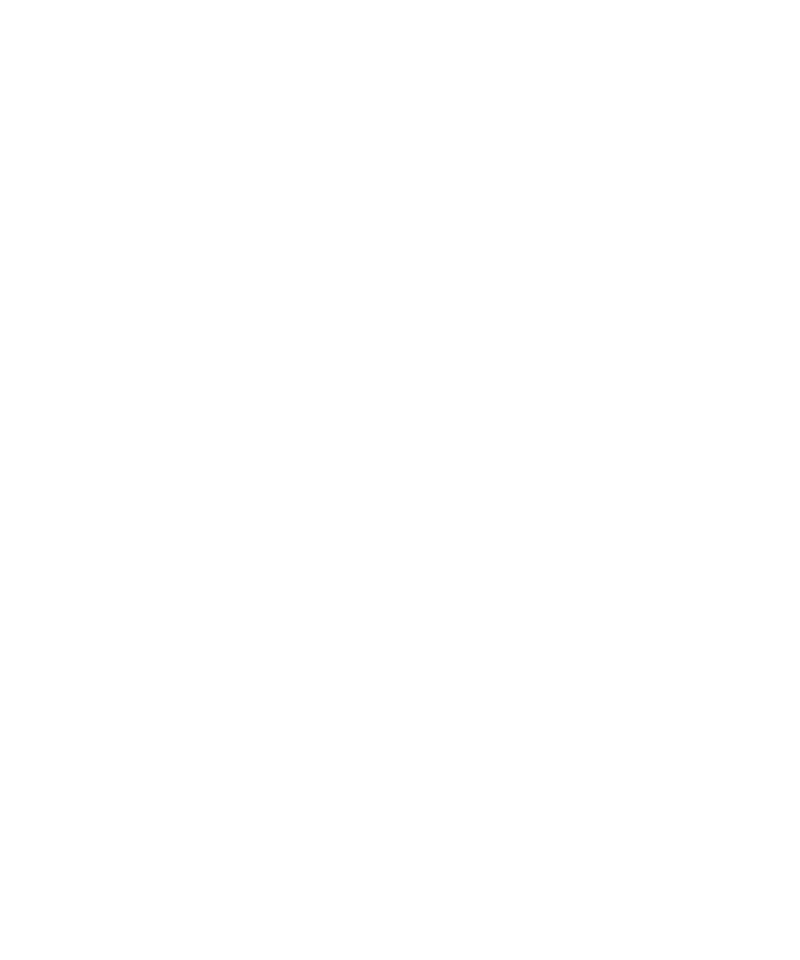

<IPython.core.display.Javascript object>


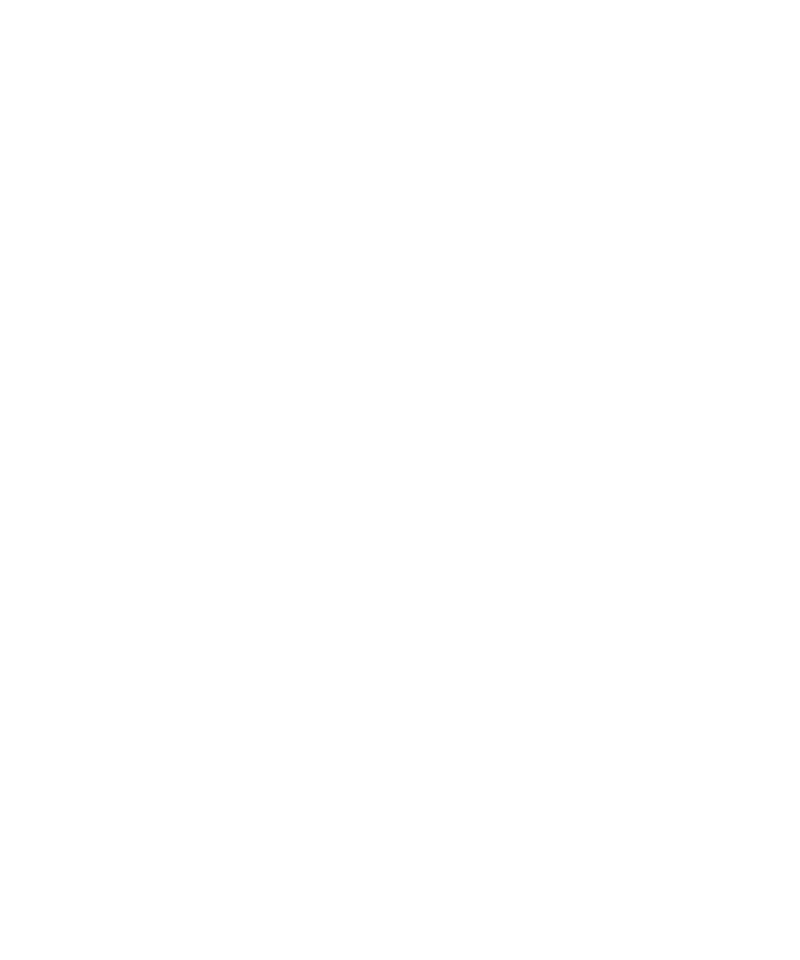

Get max intensity of ROIs in all frames: 100%|██████████| 495/495 [00:00<00:00, 11138.73it/s]


The max counts are: 3


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:01<00:00,  5.21it/s]


Histogram calculation DONE!
Total time: 0.11 min
The file: uid=5d1e13a7_fra_5_500_spec_res.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/
The difference sum of average photon counts between fit and data are: 0.0
##############################
The fitted M for Qth= 10 are: [0.010477903030042583, 0.021140769785102292]
0.000271946960585
##############################


<IPython.core.display.Javascript object>


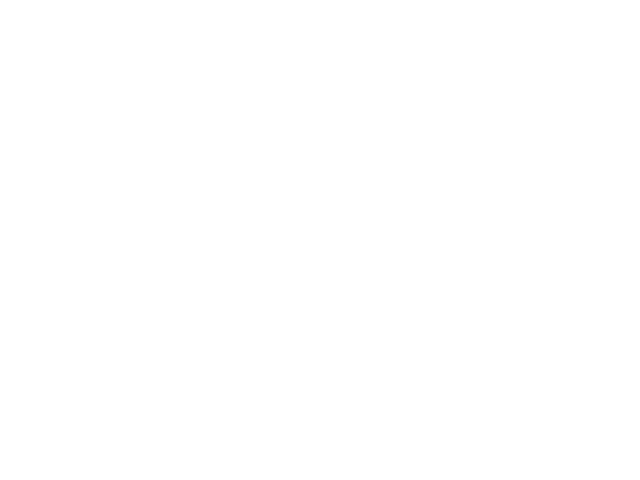

<IPython.core.display.Javascript object>


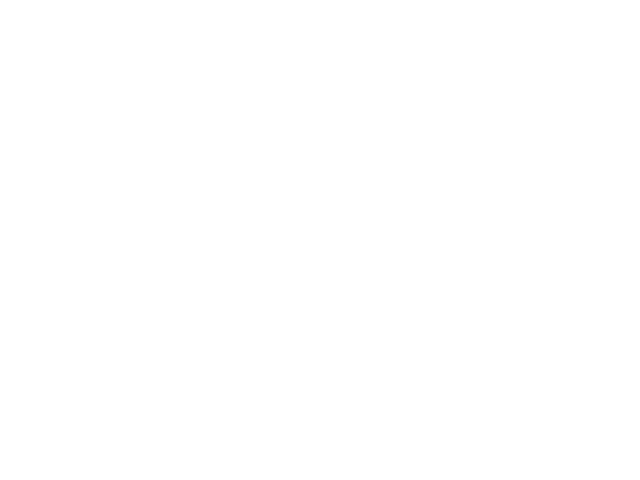

The K-M values are saved as uid=5d1e13a7_fra_5_500_xsvs_fitted_KM.csv in /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/.


<IPython.core.display.Javascript object>


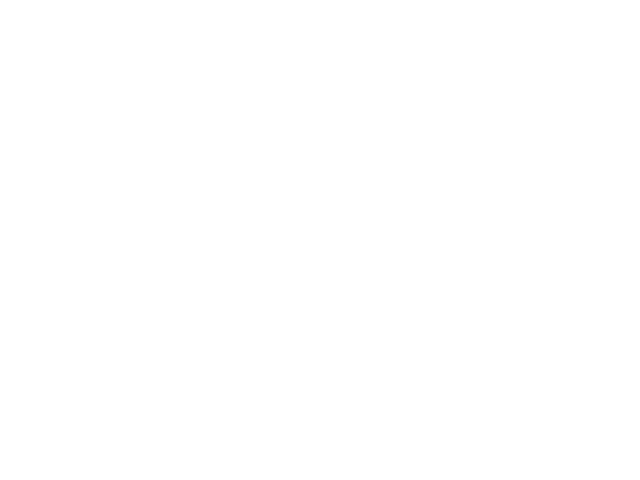

<IPython.core.display.Javascript object>


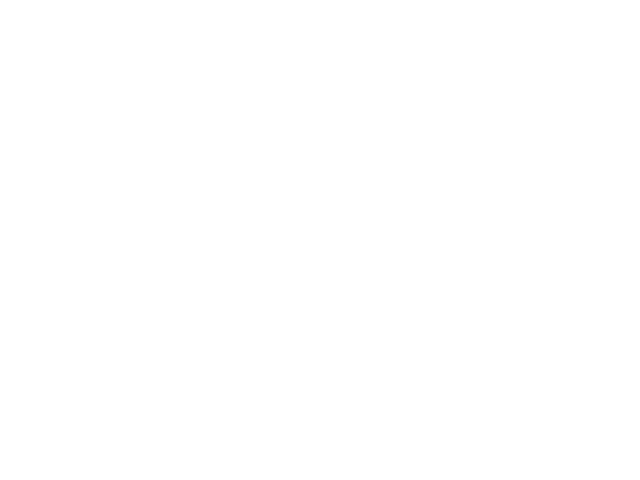

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/5d1e13a7/ with filename as uid=5d1e13a7-2c47-4869-b280-d69323a6ab85_Res.h5

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=5d1e13a7_1.pdf
****************************************
I can't attach this PDF: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_XSVS_Analysis_Report_for_uid=5d1e13a7_1.pdf due to a duplicated filename. Please give a different PDF file.
Total time: 3.26 min


In [24]:
do_loop =  True #False #True #False
if do_loop:
    multi_res = {}
    t0 = time.time()
    for uid in guids:
        multi_res[uid] = run_xpcs_xsvs_single( uid, run_pargs= run_pargs, return_res= True )
    run_time(t0)    

### For Load results

In [25]:
plt.close('all')
if not do_loop:
    multi_res = {}
    for uid, fuid in zip(guids,fuids):
        multi_res[uid] =  extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%fuid, import_dir = data_dir0 + uid +'/' )

# Get and Plot Averaged Data

In [27]:
mkeys = list(multi_res.keys())
print(mkeys)
print( multi_res[mkeys[0]].keys())

['15de40bd', '83a2889e', '5d1e13a7']
dict_keys(['spec_pds', 'wat', 'iqst', 'tausb', 'bad_frame_list', 'g2b', 'roi_mask', 'g12b', 'taus', 'mask', 'times_roi', 'imgsum', 'g2', 'avg_img', 'spec_kmean', 'times_xsvs', 'q_saxs', 'qt', 'iq_saxs', 'mean_int_sets', 'contrast_factorL', 'qval_dict'])


In [28]:
uid = uid_average
setup_pargs['uid'] = uid

In [29]:
avg_img = get_averaged_data_from_multi_res(  multi_res, keystr='avg_img' )
imgsum =  get_averaged_data_from_multi_res(  multi_res, keystr='imgsum' )
q_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='q_saxs')
iq_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='iq_saxs')
qt = get_averaged_data_from_multi_res(  multi_res, keystr='qt')
iqst = get_averaged_data_from_multi_res(  multi_res, keystr='iqst')
if run_waterfall: 
    wat = get_averaged_data_from_multi_res(  multi_res, keystr='wat')
if run_t_ROI_Inten:
    times_roi = get_averaged_data_from_multi_res(  multi_res, keystr='times_roi')
    mean_int_sets = get_averaged_data_from_multi_res(  multi_res, keystr='mean_int_sets')

if run_one_time:    
    
    g2 = get_averaged_data_from_multi_res(  multi_res, keystr='g2' )
    taus = get_averaged_data_from_multi_res(  multi_res, keystr='taus' )
    
    g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid= uid +'_g2.csv', path= data_dir, return_res=True )
    g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
        function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid  +'_g2_fit_paras.csv', path=data_dir ) 
    
if run_two_time:
    g12b = get_averaged_data_from_multi_res(  multi_res, keystr='g12b',different_length= True )
    g2b = get_averaged_data_from_multi_res(  multi_res, keystr='g2b' )
    tausb = get_averaged_data_from_multi_res(  multi_res, keystr='tausb' )
    
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid +'_g2b.csv', path= data_dir, return_res=True )
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit_general( g2b,  tausb, 
        function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= uid  + '_g2b_fit_paras.csv', path=data_dir )

if run_four_time:
    g4 = get_averaged_data_from_multi_res(  multi_res, keystr='g4' )
    taus4 = get_averaged_data_from_multi_res(  multi_res, keystr='taus4' )        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                                     qz=None, uid=uid +'_g4.csv', path= data_dir, return_res=True )
    
if run_xsvs:    
    contrast_factorL = get_averaged_data_from_multi_res(  multi_res, keystr='contrast_factorL',different_length=False )
    times_xsvs = get_averaged_data_from_multi_res(  multi_res, keystr='times_xsvs',different_length=False )
    cont_pds = save_arrays( contrast_factorL, label= times_xsvs, filename = '%s_contrast_factorL.csv'%uid,
            path=data_dir,return_res=True )
 

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/ with filename as uid=Test_120116_g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/uid=Test_120116_g2_fit_paras.csv
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/ with filename as uid=Test_120116_g2b.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/uid=Test_120116_g2b_fit_paras.csv
The file: uid=Test_120116_contrast_factorL.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/


<IPython.core.display.Javascript object>


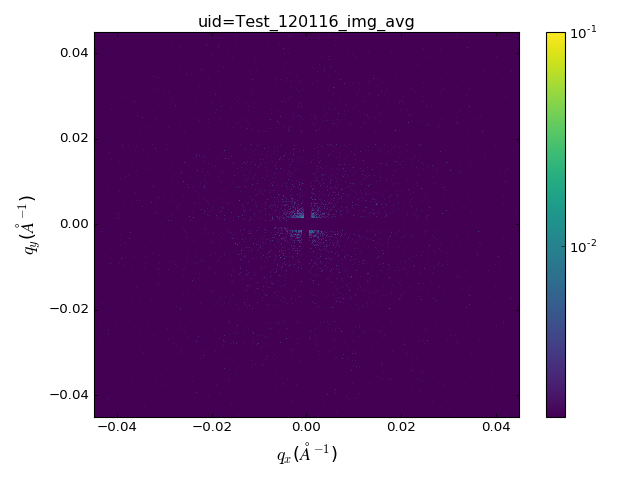

<IPython.core.display.Javascript object>


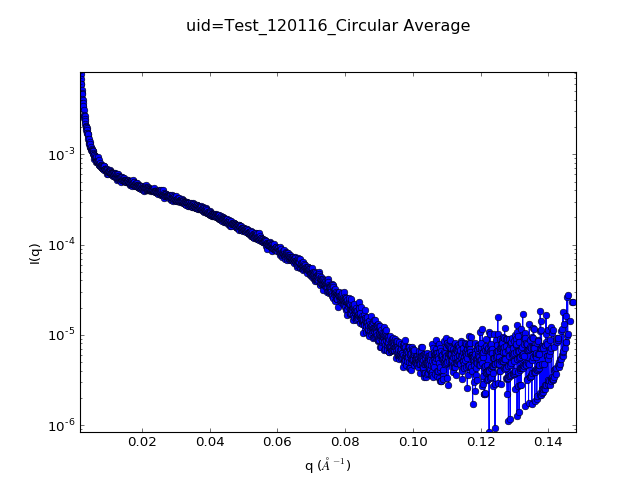

<IPython.core.display.Javascript object>


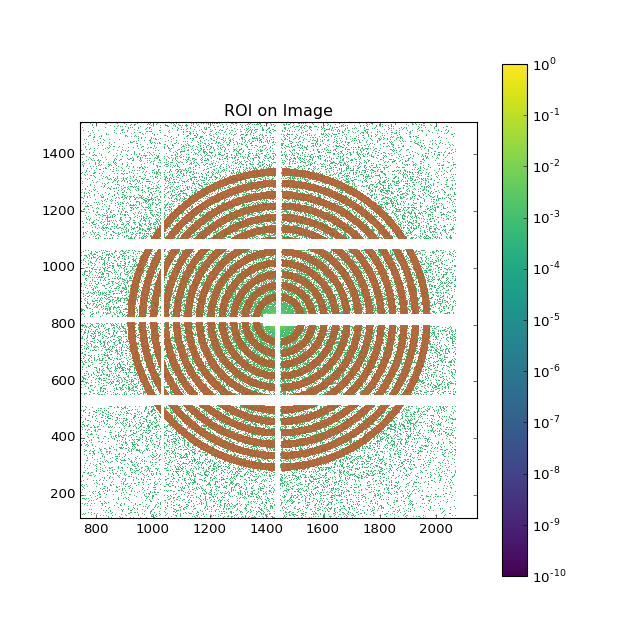

<IPython.core.display.Javascript object>


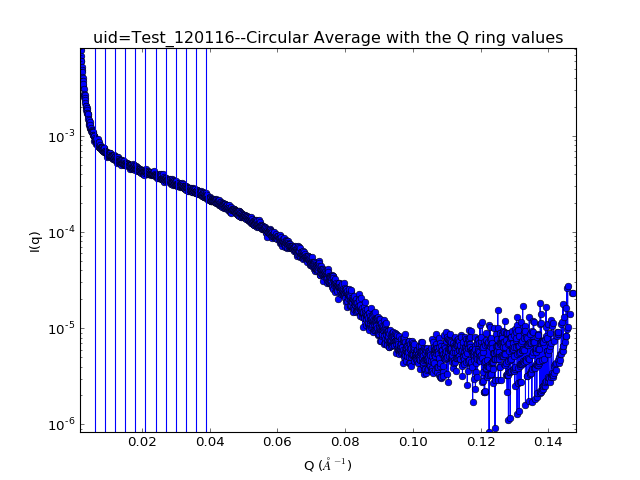

<IPython.core.display.Javascript object>


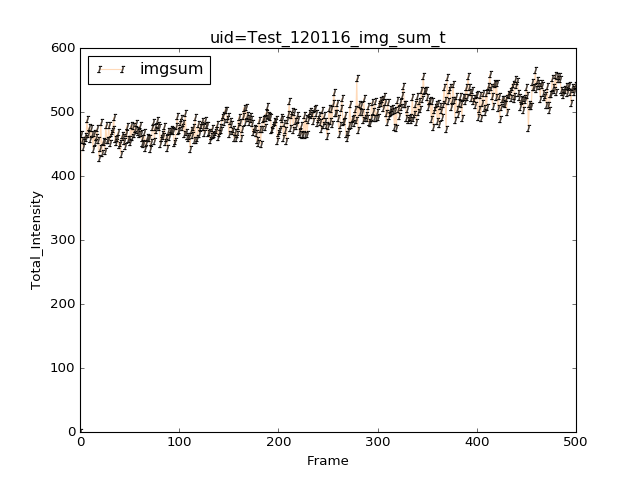

<IPython.core.display.Javascript object>


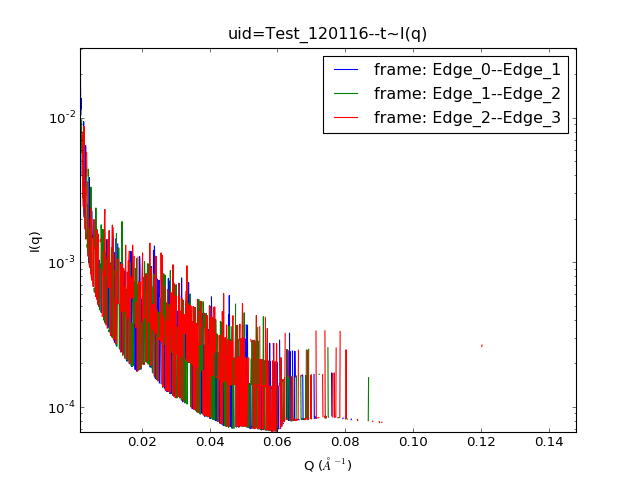

The file: uid=Test_120116_q_Iqt is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/


In [30]:
show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
               image_name= '%s_img_avg'%uid,  save=True)
plot_circular_average( q_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )
show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uid, vmin= np.min(avg_img), vmax= np.max(avg_img) )
plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uid, xlim=[q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)
plot1D( y = imgsum, title ='%s_img_sum_t'%uid, xlabel='Frame', colors='b',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)
plot_t_iqc( qt, iqst, frame_edge=None, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )


<IPython.core.display.Javascript object>


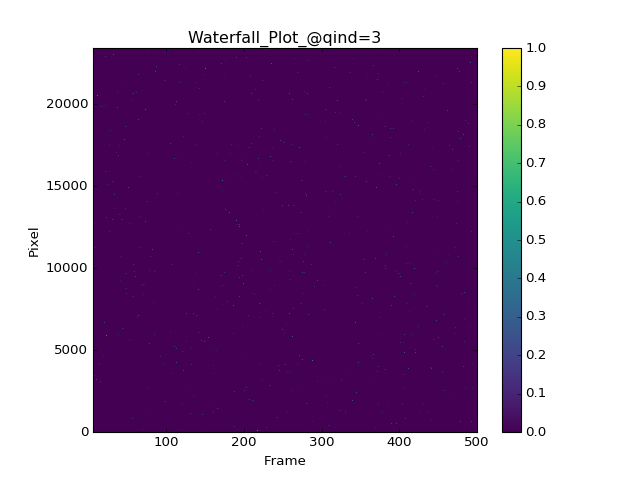

<IPython.core.display.Javascript object>


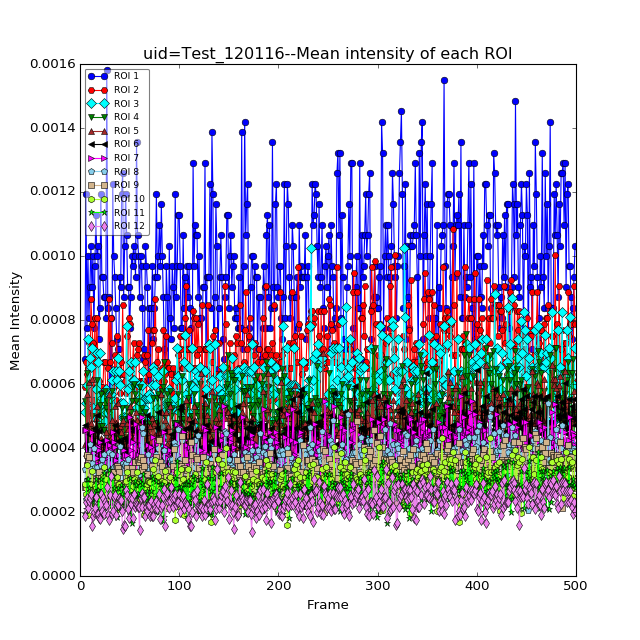

The file: uid=Test_120116_t_ROIs is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/


In [31]:
if run_waterfall: 
    plot_waterfallc( wat, qth_interest, aspect=None,vmax= np.max(wat), uid=uid, save =True, 
                    path=data_dir, beg= good_start)
if run_t_ROI_Inten:
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uid, save=True, path=data_dir )        
      

<IPython.core.display.Javascript object>


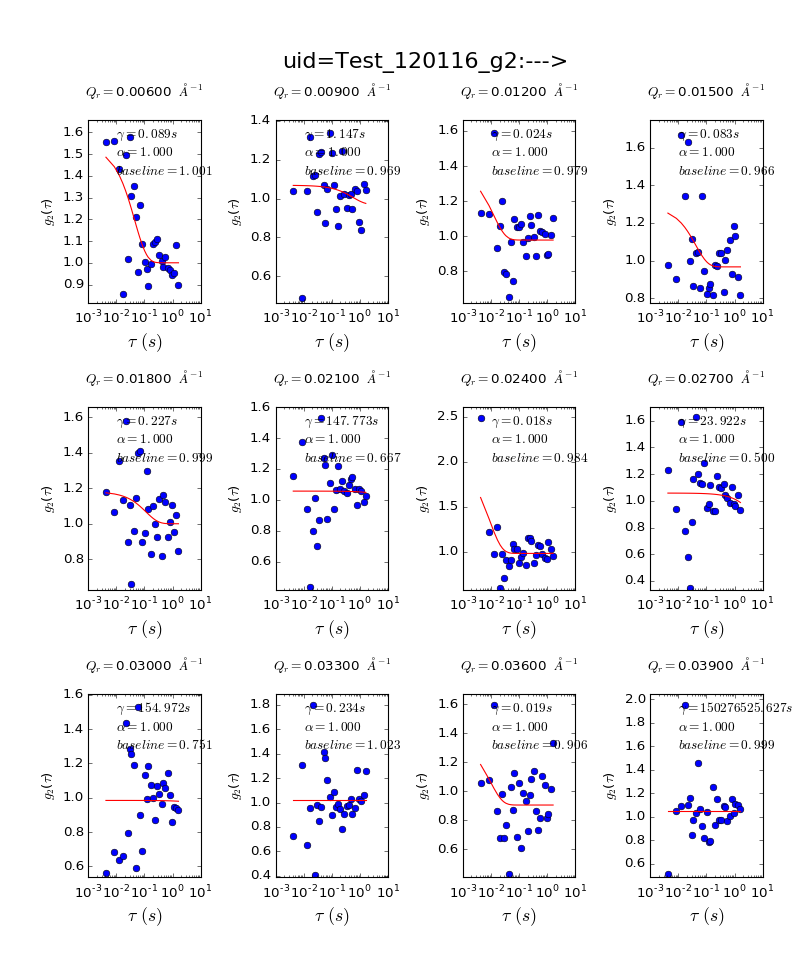

The fitted diffusion coefficient D0 is:  1.602e+04   A^2S-1


<IPython.core.display.Javascript object>


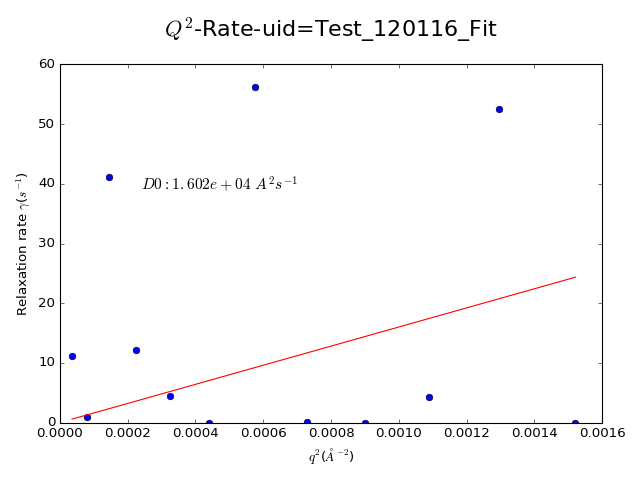

In [32]:
if run_one_time:    
    plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
        qval_dict = qval_dict, fit_res= g2_fit_result,  geometry='saxs',filename= uid +'_g2', 
            path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')

    D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'], geometry= 'saxs' )
    plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res, 
                    geometry= 'saxs',uid=uid, path= data_dir )
    
 

<IPython.core.display.Javascript object>


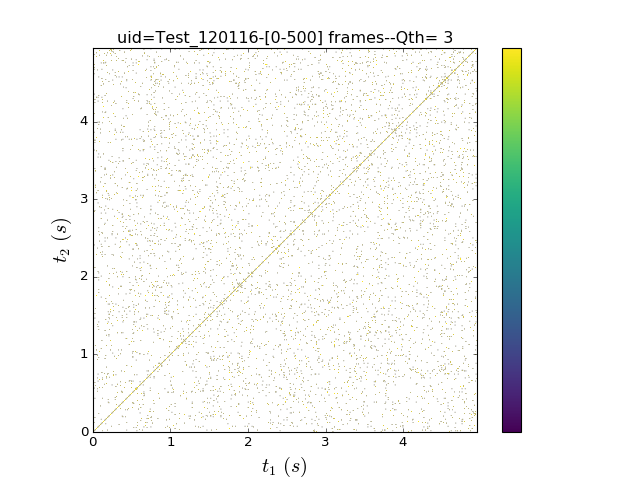

<IPython.core.display.Javascript object>


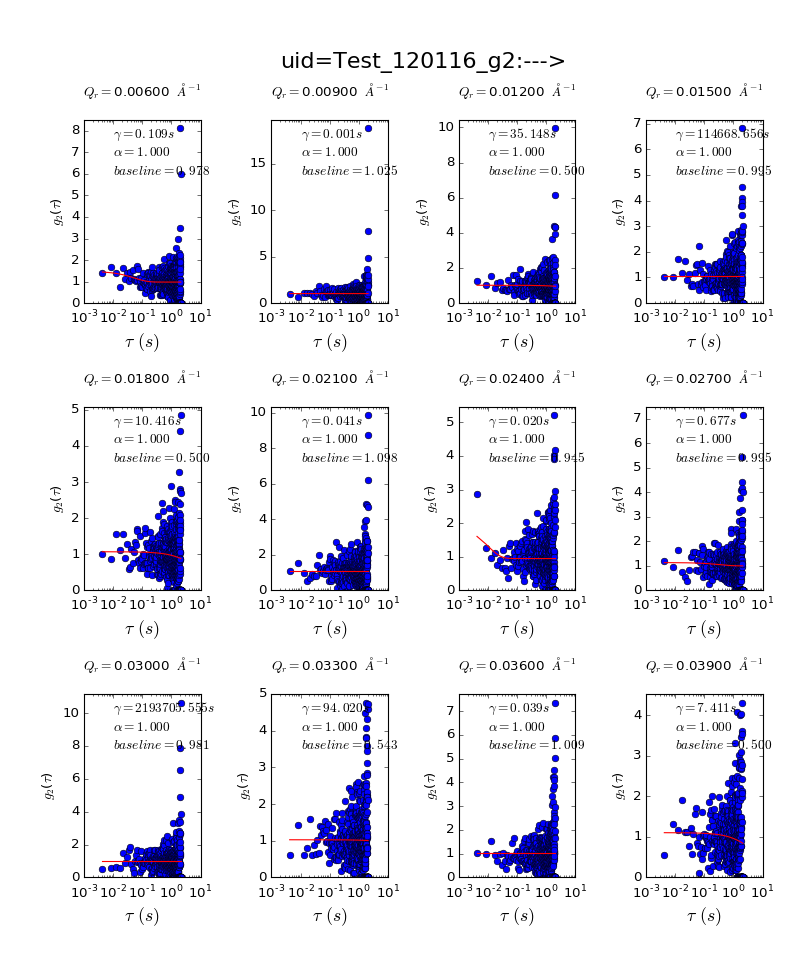

In [33]:
if run_two_time:    
    show_C12(g12b, q_ind= qth_interest, N1= 0, N2=min( len(imgsa) ,1000), vmin=1.01, vmax=1.25,
                 timeperframe=timeperframe,save=True,
                 path= data_dir, uid = uid ) 
    plot_g2_general( g2_dict={1:g2b, 2:g2_fitb}, taus_dict={1:tausb, 2:taus_fitb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2_fit_resultb,  geometry='saxs',filename=uid+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')


<IPython.core.display.Javascript object>


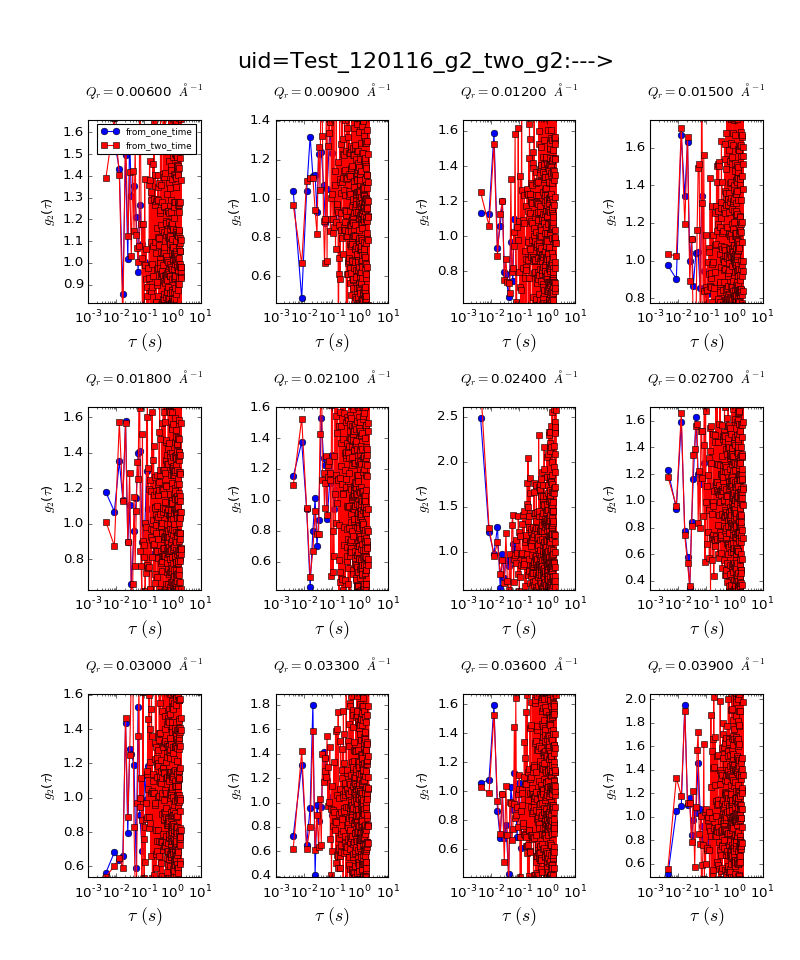

In [34]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry='saxs',filename=uid+'_g2_two_g2', path= data_dir, ylabel='g2', )
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                        geometry='saxs',filename=uid+'_g4',path= data_dir,   ylabel='g4')

<IPython.core.display.Javascript object>


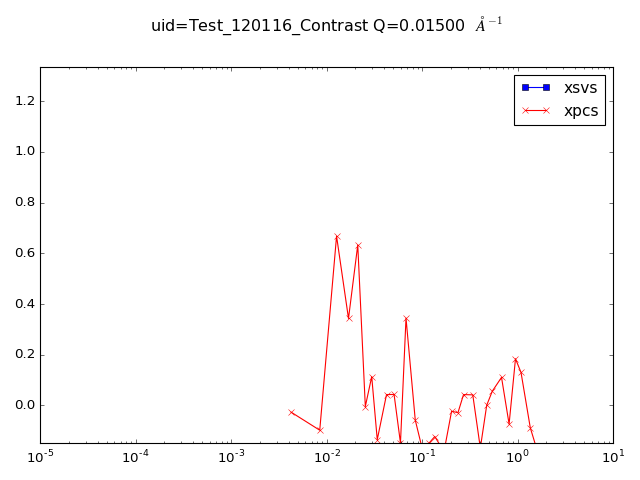

<IPython.core.display.Javascript object>


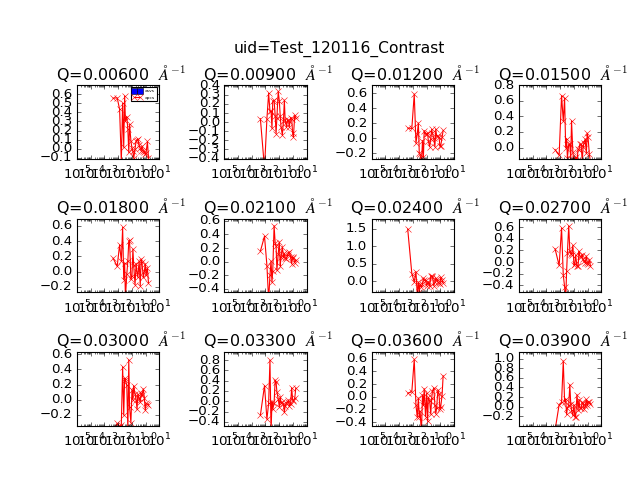

In [35]:
if run_xsvs:
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,2.0], qth = qth_interest, uid=uid,path = data_dir, legend_size=14)
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid,path = data_dir, legend_size=4)

## Export Results to a h5 files

In [36]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = 'unknown' #bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask
md['qr']= qr
md['qr_edge'] = qr_edge
md['qval_dict'] = qval_dict
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['beg'] = None
md['end'] = None
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + '%s_md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + '%s_md.csv'%uid, 'w')

Exdt = {} 
for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum'  ], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum ] ):
    Exdt[ k ] = v
if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['times_xsvs','contrast_factorL'],[times_xsvs,contrast_factorL] ):
        Exdt[ k ] = v        


In [37]:
if run_xsvs:
    contr_pds = save_arrays( Exdt['contrast_factorL'], label= Exdt['times_xsvs'],
                       filename = '%s_contr.csv'%uid, path=data_dir,return_res=True )

The file: uid=Test_120116_contr.csv is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/


In [38]:
export_xpcs_results_to_h5( uid + '_Res.h5', data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = uid + '_Res.h5', import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/ with filename as uid=Test_120116_Res.h5


## Create PDF report for each uid

In [46]:
pdf_out_dir = data_dir
pdf_filename = "XPCS_Analysis_Report_for_%s%s.pdf"%(uid_average,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_%s%s.pdf"%(uid_average,pdf_version)

In [40]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

In [47]:
make_pdf_report( data_dir, uid_average, pdf_out_dir, pdf_filename, username, 
                    run_fit_form, run_one_time, run_two_time, run_four_time, run_xsvs
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/Test_120116/XPCS_XSVS_Analysis_Report_for_uid=Test_120116_1.pdf
****************************************


### Attach each g2 result to the corresponding olog entry

In [48]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add XPCS Averaged Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Averaged Analysis PDF Report and with the attachments


In [43]:
fuids[-1]

'5d1e13a7-2c47-4869-b280-d69323a6ab85'

# The End!